# 1. Project Overview

This notebook is producted as part of University of Essex Online Maching Learning Group Project. The project will analyse the Airbnb New York Open Dataset (2019) to answer the following question:

**What are the primary factors that affect the listing price of properties on Airbnb, and how can these insights help hosts achieve the most value from their listings?**



---



The project will include five pieces of data analysis, contributed by each member of the team, intended to answer the following questions:

1. **Exploratory Data Analysis**

  This section will include initial exploratory data analysis. It will focus on descriptive elements, exploring the structure and nature of the data, relationships between variables, and summary statistics. It will utilise visual tools including histograms, heatmaps and scatter plots.

2. **Minimum Nights**:

  This section will investigate the link between the minimum number of nights and the price and bookings.

3. **Room Type**:

  This section will deep dive into the room type and price.

4. **Geographic Location and Neighbourgood**:

  This section will focus on the relationship between the price and location of property listings.  It will utilise geospatial analysis to provide visual insights into the data.

5. **Listing Name and Description**:

  This section attempt to uncover insights relating to the listing name and description, understanding whether the name has a meaningful impact on price and bookings.





# 2. Notebook Setup

The first step is to check that all necessary packages are installed.

For this project, the following packages are required:
1. **matplotlib**: This will be used for plotting data during exploratory data analysis.
2. **Seaborn**: This will be used for plotting data during exploratory data analysis.
3. **Pandas**: This will be used for exploratory data analysis and data pre-processing/feature engineering.
4. **sckit-learn**: This will include the KMeans model for the use of the K Means Clustering algorithm for data analysis.

The following command lists all packages installed into the current environment. The output shows that all required packages are already installed.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import pearsonr, f_oneway
import geopandas as gpd
from google.colab import output
output.enable_custom_widget_manager()
import statsmodels.api as sm
import kagglehub
import os
import glob
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression

The next step is it import the data.

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving AB_NYC_2019.csv to AB_NYC_2019.csv


## Initial Overview of Data

**Load Dataset:**

In [ ]:
data_raw = pd.read_csv("AB_NYC_2019.csv")

The following commands provide an overview of the data to help identify potential data pre-processing that may be required.

In [ ]:
data_raw.shape

(48895, 16)

This is a large dataset, containing 16 features and 48895 individual observations.

In [ ]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

The data includes:
* 16 columns (or features)
* 48995 rows (or observations)
* Various data types: float64(3), int64(7), object(6)
* Some columns with null entries (missing data)

In [ ]:
data_raw.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

Noting the data types above, several features would benefit from adjustments to better match the type of data and enable more efficient analysis. Key variables that require data type changes are described below:

- **last_review**
  - **Current Data Type**: `object`
  - **New Data Type**: `datetime`
  - **Reason**: Enables analysis related to dates and time-series, improving time-based filtering and calculations.

- **neighbourhood_group**, **neighbourhood**, **room_type**
  - **Current Data Type**: `object`
  - **New Data Type**: `category`
  - **Reason**: Supports category labeling and structured data analysis, which improves memory usage and enables categorical modeling techniques.

- **latitude**, **longitude**
  - **Current Data Type**: `object`
  - **New Data Type**: `float64`
  - **Reason**: Required for accurate calculations and compatibility with geospatial packages like `geopandas`.

# 3. General EDA

## Data Type Transformation

This code transforms the data as described above. Different approaches may be taken in subsequent analyses, but this demonstrates how data can be transformed.

In [ ]:
data_raw['last_review'] = pd.to_datetime(data_raw['last_review'], errors='coerce')
data_raw['neighbourhood_group'] = data_raw['neighbourhood_group'].astype('category')
data_raw['neighbourhood'] = data_raw['neighbourhood'].astype('category')
data_raw['room_type'] = data_raw['room_type'].astype('category')
data_raw['latitude'] = data_raw['latitude'].astype('float64')
data_raw['longitude'] = data_raw['longitude'].astype('float64')

## Missing Values

Understanding and addressing missing values is essential. The quantity, distribution, and significance of each variable influence how missing values should be treated.

Common approaches for handling missing values include:
- **Dropping columns**: Appropriate if there are excessive missing values if the features are not essential to the analysis.
- **Dropping rows**: Typically appropraite if there are just a few rows with missing values.
- **Imputation**: Missing values are filled with new values. Simple methods include adding an average based on other values, or more advanced techniques, like regression or KNN.

In [ ]:
# Calculate the percentage of missing values for each column
missing_percentage = data_raw.isnull().mean() * 100

# Sort by percentage of missing values in descending order
missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=False)

# Display the result
print(missing_percentage)

last_review          20.558339
reviews_per_month    20.558339
host_name             0.042949
name                  0.032723
dtype: float64


Both 'last_review' and 'reviews_per_month' have a high percentage of missing values - but notably, they have exactly the same percentage of missing value. This indicates two potential scenarios:
1. A large number of listings missing data. Based on the data this is less likely.
2. The missing values indicate zero reviews. As a proxy for bookings, if proven, this is useful data, as knowing that a property is useful for analysis as it allows us to explore why.

The other two are both under 5%, but are also less useful for quantitive analysis. As text fields, imputation would not be useful in this context. These should be reviewed and a decision whether to keep or exclude the coulmns or rows should be made.



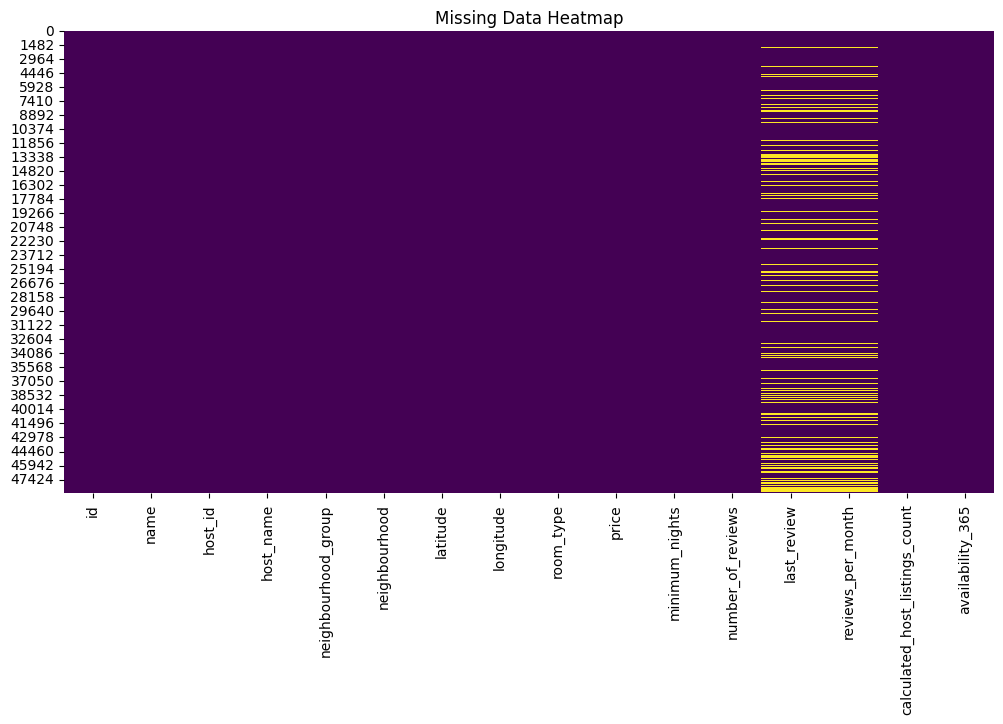

In [ ]:
# Visualize missing data
plt.figure(figsize=(12, 6))
sns.heatmap(data_raw.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Data Heatmap")
plt.show()

**Last Review**

The heatmap visually confirms that the missing values appear in the same observations for both last_review and reviews_per_month, suggesting that this indeed relates to properties with no bookings.

In [ ]:
# Identify rows where reviews are missing
missing_reviews = data_raw[data_raw['last_review'].isnull() & data_raw['reviews_per_month'].isnull()]

# Calculate the number of such rows
num_missing_reviews = missing_reviews.shape[0]
print(f"Number of rows missing reviews: {num_missing_reviews}")



Number of rows missing reviews: 10052


Null Correlation Matrix:
                                id      name  host_id  host_name  \
id                             NaN       NaN      NaN        NaN   
name                           NaN  1.000000      NaN  -0.000375   
host_id                        NaN       NaN      NaN        NaN   
host_name                      NaN -0.000375      NaN   1.000000   
neighbourhood_group            NaN       NaN      NaN        NaN   
neighbourhood                  NaN       NaN      NaN        NaN   
latitude                       NaN       NaN      NaN        NaN   
longitude                      NaN       NaN      NaN        NaN   
room_type                      NaN       NaN      NaN        NaN   
price                          NaN       NaN      NaN        NaN   
minimum_nights                 NaN       NaN      NaN        NaN   
number_of_reviews              NaN       NaN      NaN        NaN   
last_review                    NaN  0.018777      NaN   0.001668   
reviews_per_month      

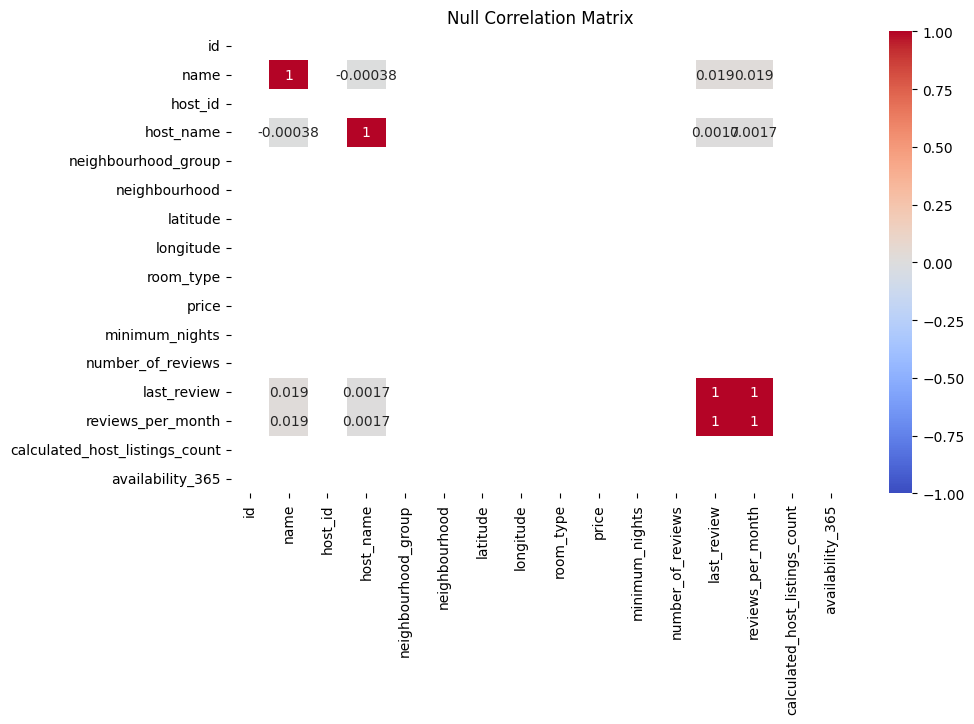

In [ ]:
# Create a binary matrix where 1 indicates a missing value and 0 indicates no missing value
missing_matrix = data_raw.isnull().astype(int)

# Compute the correlation matrix for the missingness
missing_corr = missing_matrix.corr()

# Display the null correlation matrix
print("Null Correlation Matrix:")
print(missing_corr)

# Visualise the null correlation matrix as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(missing_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Null Correlation Matrix")
plt.show()

The null correlation matrix confirms that rows missing reviews per month will also not include a last review date.

## Summary Statistics

### Numerical

In [ ]:
data_raw.describe()

id       host_id      latitude     longitude         price  \
count  4.889500e+04  4.889500e+04  48895.000000  48895.000000  48895.000000   
mean   1.901714e+07  6.762001e+07     40.728949    -73.952170    152.720687   
min    2.539000e+03  2.438000e+03     40.499790    -74.244420      0.000000   
25%    9.471945e+06  7.822033e+06     40.690100    -73.983070     69.000000   
50%    1.967728e+07  3.079382e+07     40.723070    -73.955680    106.000000   
75%    2.915218e+07  1.074344e+08     40.763115    -73.936275    175.000000   
max    3.648724e+07  2.743213e+08     40.913060    -73.712990  10000.000000   
std    1.098311e+07  7.861097e+07      0.054530      0.046157    240.154170   

       minimum_nights  number_of_reviews                    last_review  \
count    48895.000000       48895.000000                          38843   
mean         7.029962          23.274466  2018-10-04 01:47:23.910099456   
min          1.000000           0.000000            2011-03-28 00:00:00   
25%          1.000000           1.000000            2018-07-08 00:00:00   
50%          3.000000           5.000000            2019-05-19 00:00:00   
75%          5.000000          24.000000            2019-06-23 00:00:00   
max       1250.000000         629.000000            2019-07-08 00:00:00   
std         20.510550          44.550582                            NaN   

       reviews_per_month  calculated_host_listings_count  availability_365  
count       38843.000000                    48895.000000      48895.000000  
mean            1.373221                        7.143982        112.781327  
min             0.010000                        1.000000          0.000000  
25%             0.190000                        1.000000          0.000000  
50%             0.720000                        1.000000         45.000000  
75%             2.020000                        2.000000        227.000000  
max            58.500000                      327.000000        365.000000  
std             1.680442                       32.952519        131.622289

The summary statistics provide some useful insights that warrant further investigation.

* **Price**:
  * Mean of 152.72, with a Median of 106.
  * The data likely contains extreme outliers, resulting in a high positive skew.
  * The minimum value of $0 indicates potential missing data - this warrants further investigation.

* **Minimum Nights**:
  * With a median of 3, mean of 7 and maximum of 1250, this variable is highly skewed. The maximum is antithetical to the Airbnb model, so further investigation of outliers would be requirements.

* **Number of Reviews**: Again, the is highly skewed, with a large standard deviation. The third quartile is 24, so this suggests that there are a minority of properties that make up the majority of the bookings, if this variable is taken as a proxy for bookings.

* **Reviews per Month**: An interesting statistic to note here is the max 58.5 reviews per month. This is an interesting number as it suggests over 2 reviews per day. As a proxy for bookings and popularity, this warrants further investigation. The data could include outliers, or the reviews might be impacted by multiple people reviewing a single stay.

* **Calculated Host Listings Count**: This data indicates that the data may contain a smaller number of hosts with a large proportion of properties. This warrants further investigation. If the most popular properties are listed by hosts with large numbers of property, as it could indicate a professionalisation of the AirBnb property market.


####Distribution

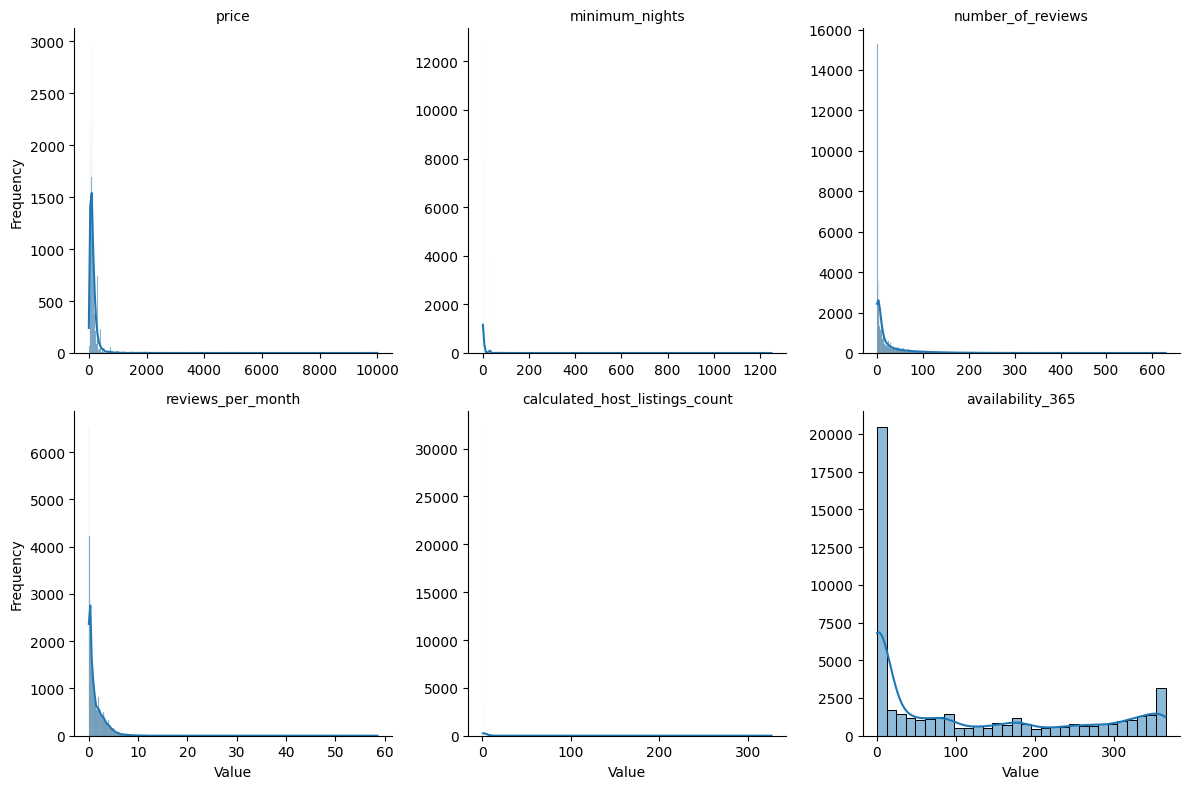

In [ ]:
# Select numerical columns excluding specified variables
numerical_data = data_raw.select_dtypes(include='number').drop(columns=['id', 'longitude', 'latitude', 'host_id'])

# Melt the DataFrame for use with FacetGrid
melted_data = numerical_data.melt(var_name='Variable', value_name='Value')

# Create the histograms
g = sns.FacetGrid(melted_data, col='Variable', col_wrap=3, sharex=False, sharey=False, height=4)
g.map(sns.histplot, 'Value', kde=True)

# Set titles and labels
g.set_titles("{col_name}")
g.set_axis_labels("Value", "Frequency")
g.tight_layout()
plt.show()

Key Observations from the Histograms

1.	price:

  Heavily skewed to the right (positive skewness) with a long tail of very high values.

  The presence of extreme outliers (e.g., prices exceeding $2,000) suggests that cleaning or capping outliers may improve analysis accuracy.

2.	minimum_nights:

  Extremely skewed with a long tail, showing most properties have low minimum nights, but some listings have values up to 1,200 nights. These extreme values likely represent data errors or rare edge cases.

3.	number_of_reviews:

  Highly skewed with most properties having few reviews (close to 0) but some with very high numbers (up to 600). These outliers could represent extremely popular properties.

4.	reviews_per_month:

  Similar skewness to number_of_reviews. Most properties receive very few reviews monthly, but some extreme outliers suggest unusually high activity, which may need further investigation.

5.	calculated_host_listings_count:

  Shows a clear peak at lower values, indicating that most hosts manage few properties. However, a long tail suggests a few hosts manage a large number of properties, indicative of professionalization in the market.

6.	availability_365:

  The distribution suggests a significant number of properties are rarely available (close to 0) or always available (close to 365). This binary-like pattern could indicate hosts using Airbnb for specific time periods (e.g., only during tourist seasons).

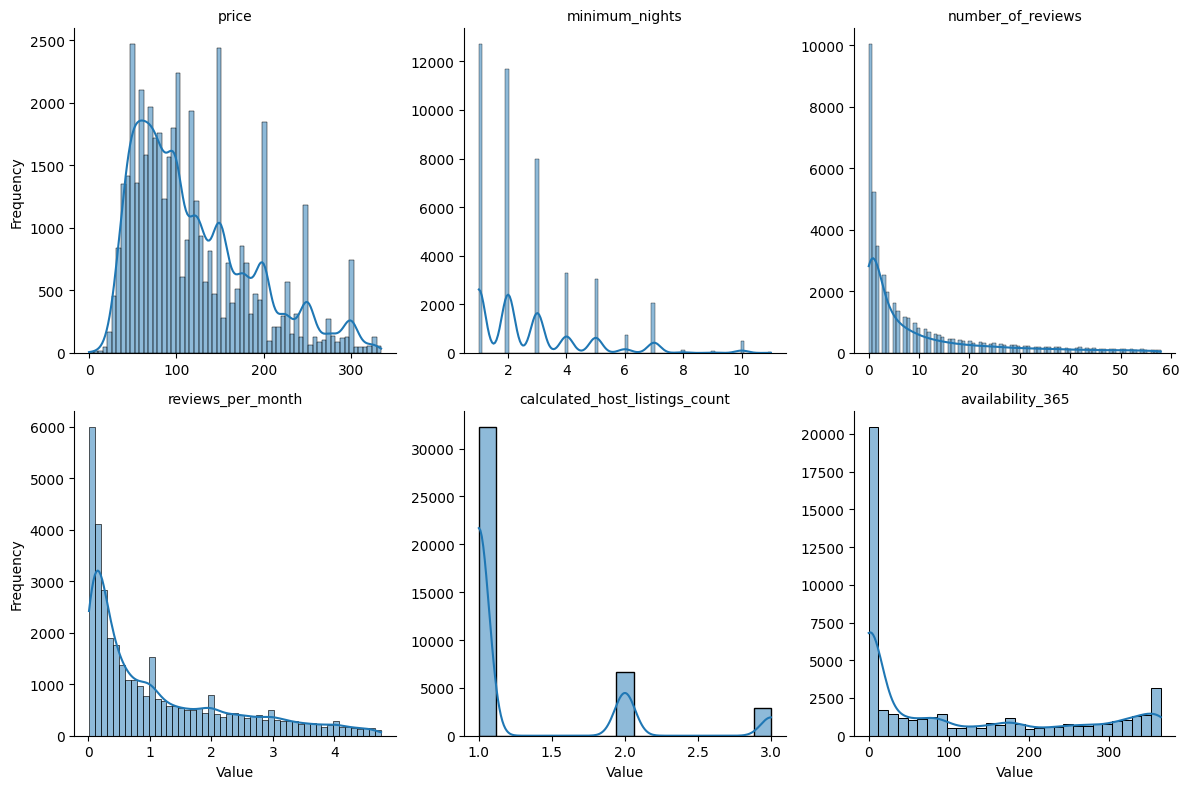

In [ ]:
# Define a function to remove outliers based on the IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    # Filter out rows with outliers
    return df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]

# Select numerical columns excluding specified variables
numerical_data = data_raw.select_dtypes(include='number').drop(columns=['id', 'host_id', 'longitude', 'latitude'])

# Create a new dataset without outliers
data_less_outliers = pd.DataFrame()  # to store cleaned data
for column in numerical_data.columns:
    cleaned_col_data = remove_outliers(numerical_data, column)
    cleaned_col_data = cleaned_col_data[[column]]
    data_less_outliers = pd.concat([data_less_outliers, cleaned_col_data], axis=1)

# Melt data for faceting
melted_data = data_less_outliers.melt(var_name='Variable', value_name='Value')

# Initialise the FacetGrid
g = sns.FacetGrid(melted_data, col='Variable', col_wrap=3, sharex=False, sharey=False, height=4)

# Map a histogram with KDE onto each subplot
g.map(sns.histplot, 'Value', kde=True)

# Adjust layout and add titles
g.set_titles("{col_name}")
g.set_axis_labels("Value", "Frequency")
g.tight_layout()
plt.show()

1.	price:

  The distribution is now more uniform and less skewed.Extreme values (e.g., prices above $1,000) have been removed, making the data more representative of typical listings.
  
  Most listings fall between 50 USD and 300 USD, which aligns better with realistic Airbnb pricing.

2.	minimum_nights:

  The long tail of extreme values (e.g., 1,200 nights) has been removed.

  The cleaned data reflects typical Airbnb booking patterns, with most listings requiring 1–5 nights as a minimum.

3.	number_of_reviews:
  
  The distribution remains slightly skewed but shows fewer extreme values (e.g., properties with 600+ reviews).
  
  Most properties still have a small number of reviews, highlighting the dominance of less popular listings.

4.	reviews_per_month:
  
  Skewness has decreased, and extreme activity levels have been removed.
  
  Most listings now cluster around 0–2 reviews per month, representing a realistic level of booking activity.

5.	calculated_host_listings_count:
  
  The cleaned distribution now shows clearer groupings, reflecting hosts with fewer properties.

  Hosts managing one property dominate, but smaller peaks for hosts with 2 or 3 listings remain visible.

6.	availability_365:

  The binary-like distribution persists (0 or 365 availability), suggesting seasonal or year-round availability.

  Removing extreme values doesn’t significantly alter the shape but makes the distribution slightly smoother.

####Correlation

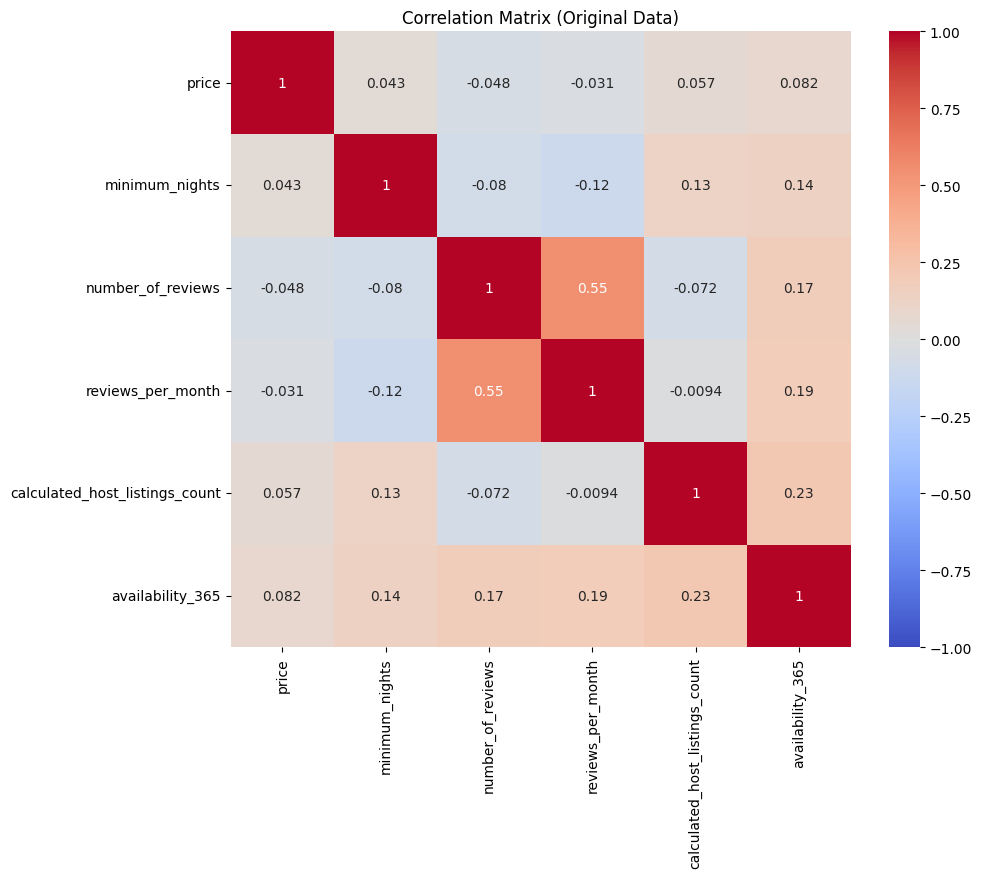

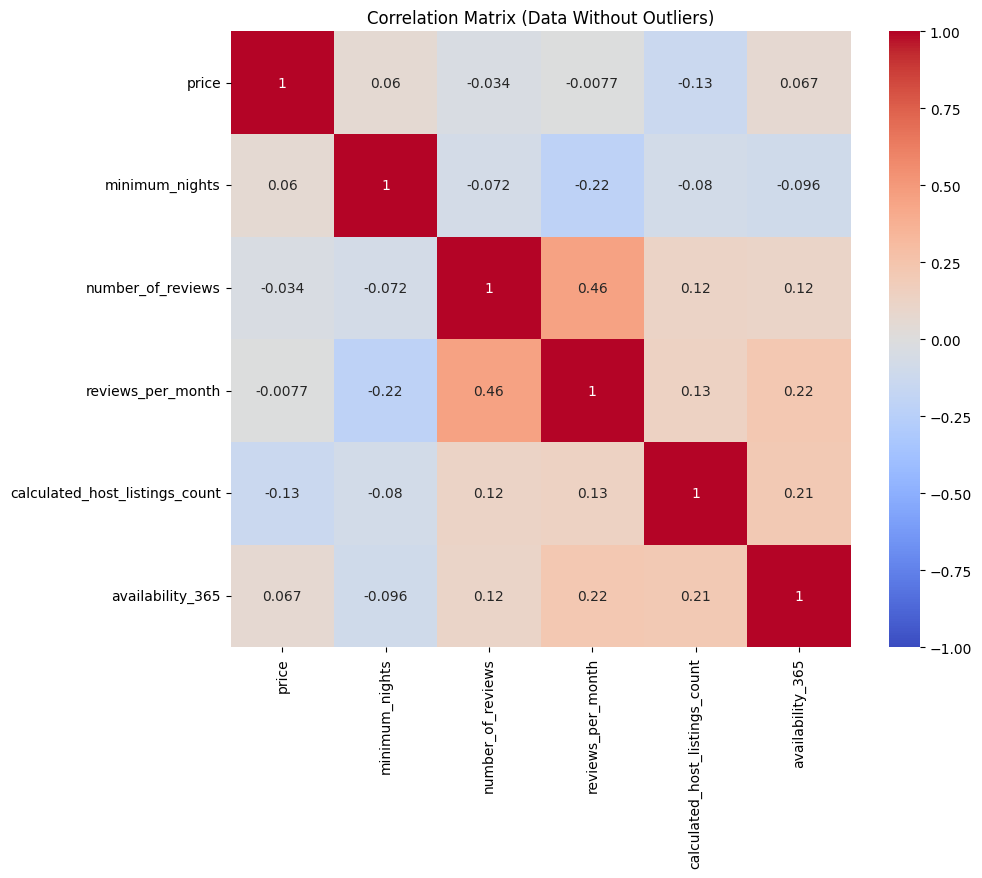

In [ ]:
# Define columns to exclude
excluded_columns = ['id', 'host_id', 'latitude', 'longitude']

# Filter numerical columns excluding the specified columns for data_raw
numerical_data_raw = data_raw.select_dtypes(include='number').drop(columns=excluded_columns)

# Calculate the correlation matrix for data_raw
corr_matrix_raw = numerical_data_raw.corr()

# Plot the correlation matrix for data_raw
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_raw, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix (Original Data)")
plt.show()

# Filter numerical columns excluding the specified columns for data_less_outliers
numerical_data_less_outliers = data_less_outliers.select_dtypes(include='number').drop(columns=excluded_columns)

# Calculate the correlation matrix for data_less_outliers
corr_matrix_less_outliers = numerical_data_less_outliers.corr()

# Plot the correlation matrix for data_less_outliers
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_less_outliers, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix (Data Without Outliers)")
plt.show()


Analysis without outliers.


- **Number of Reviews and Reviews per Month**: There is a moderate positive correlation (0.46) between these two variables. This suggests that listings with a higher review frequency tend to accumulate more reviews over time.

- **Availability**:
  - Availability shows a weak positive correlation with Reviews per Month (0.22) and Host Listing Count (0.21). This suggests that listings with higher availability may receive more reviews per month and tend to belong to hosts with multiple listings, indicating active or highly available hosts.

- **Minimum Nights**:
  - There is a slight negative correlation between Minimum Nights and Reviews per Month (-0.22). This implies that listings with a higher minimum stay requirement tend to receive fewer reviews per month, likely due to lower booking frequency.

- **Price**:
  - Price shows very weak correlations with other variables, with no correlation above 0.13. This indicates that price variability does not strongly impact availability, review frequency, or host listing count in this dataset.

- **Host Listing Count**:
  - There is a small positive correlation between Host Listing Count and Reviews per Month (0.13), suggesting that hosts with multiple listings may receive slightly more reviews on average, though the correlation is weak.

- **Overall Pattern**:
  - Most correlations are relatively weak, suggesting few strong linear relationships among these variables. This may indicate that other factors (not included in this dataset) could be influencing metrics like price or availability.

In summary, **Number of Reviews** and **Reviews per Month** show a moderate correlation, while **Availability** has slight positive correlations with a few other factors. Other variables, like **Price** and **Host Listing Count**, display minimal relationships, indicating weak associations overall among these features.


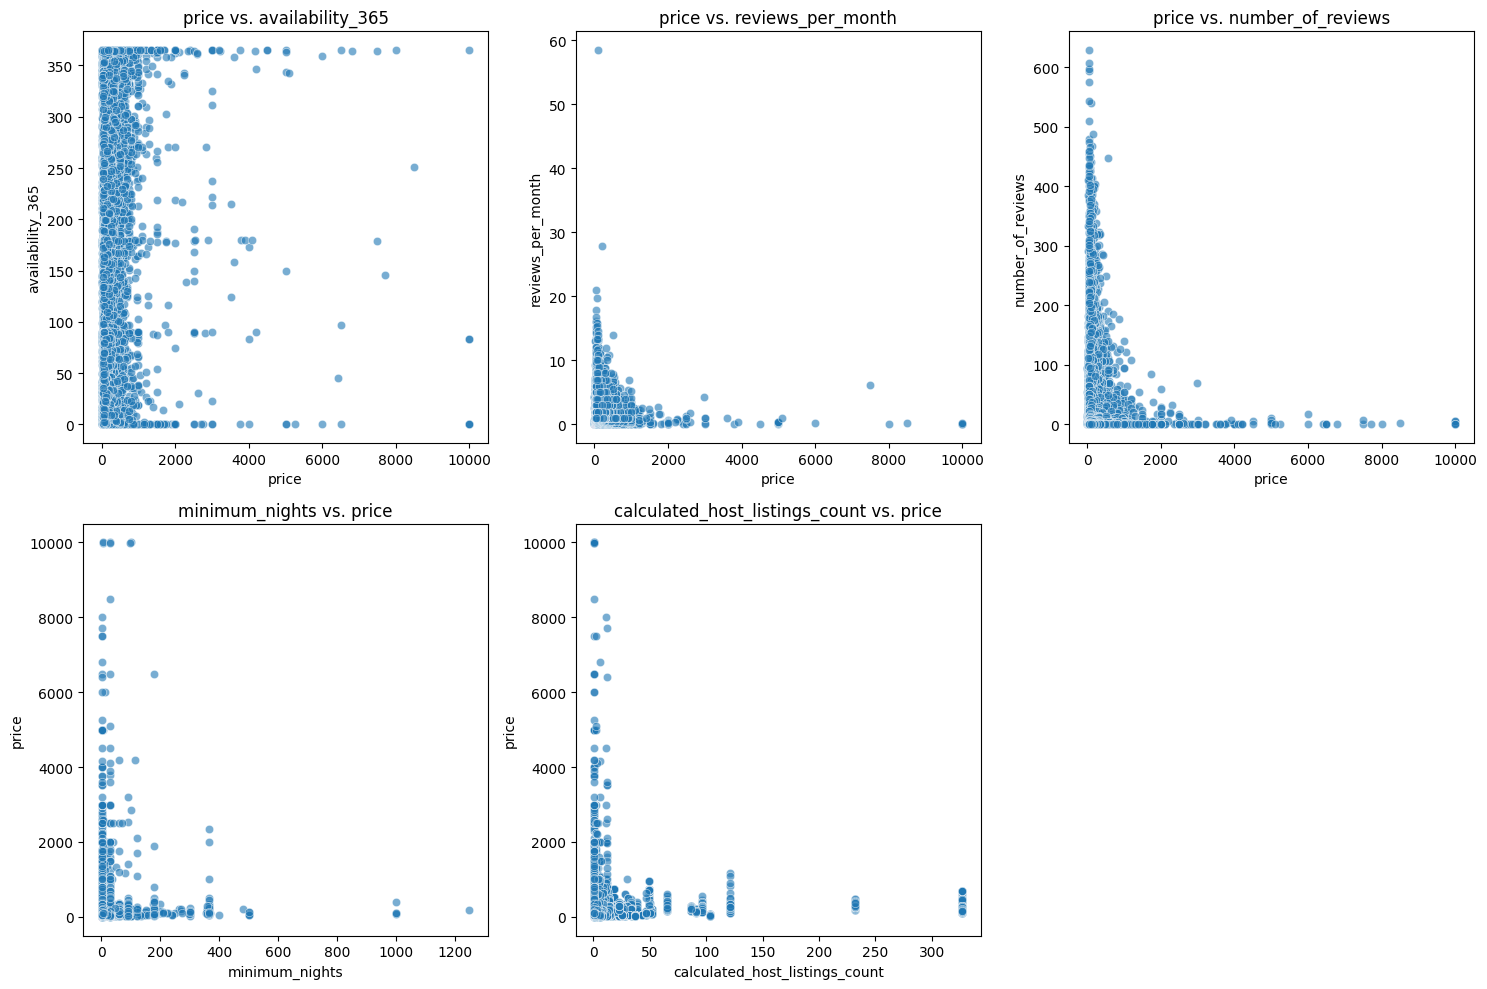

In [ ]:
# Define pairs of variables for scatter plots to examine relationships
bivariate_pairs = [
    ('price', 'availability_365'),
    ('price', 'reviews_per_month'),
    ('price', 'number_of_reviews'),
    ('minimum_nights', 'price'),
    ('calculated_host_listings_count', 'price')
]

# Set up the plot area
plt.figure(figsize=(15, 10))

# Generate scatter plots for each pair
for i, (x, y) in enumerate(bivariate_pairs, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=data_raw, x=x, y=y, alpha=0.6)
    plt.title(f'{x} vs. {y}')
    plt.xlabel(x)
    plt.ylabel(y)

# Adjust layout
plt.tight_layout()
plt.show()

###Categorical

In [ ]:
# Select only categorical columns from data_raw and get frequency counts for each category
categorical_data = data_raw.select_dtypes(include='category')
category_counts = {col: categorical_data[col].value_counts() for col in categorical_data.columns}

# Display the results in a structured format
category_counts

{'neighbourhood_group': neighbourhood_group
 Manhattan        21661
 Brooklyn         20104
 Queens            5666
 Bronx             1091
 Staten Island      373
 Name: count, dtype: int64,
 'neighbourhood': neighbourhood
 Williamsburg          3920
 Bedford-Stuyvesant    3714
 Harlem                2658
 Bushwick              2465
 Upper West Side       1971
                       ... 
 Richmondtown             1
 Willowbrook              1
 Fort Wadsworth           1
 New Dorp                 1
 Woodrow                  1
 Name: count, Length: 221, dtype: int64,
 'room_type': room_type
 Entire home/apt    25409
 Private room       22326
 Shared room         1160
 Name: count, dtype: int64}

This shows a frequency count of some of the key categorical data - showing the most popular neighbourhoods, and a split of room type.

Both of these are suitable candidate groups for further investigation and breakdown, especially useful for more targeted pricing strategies.


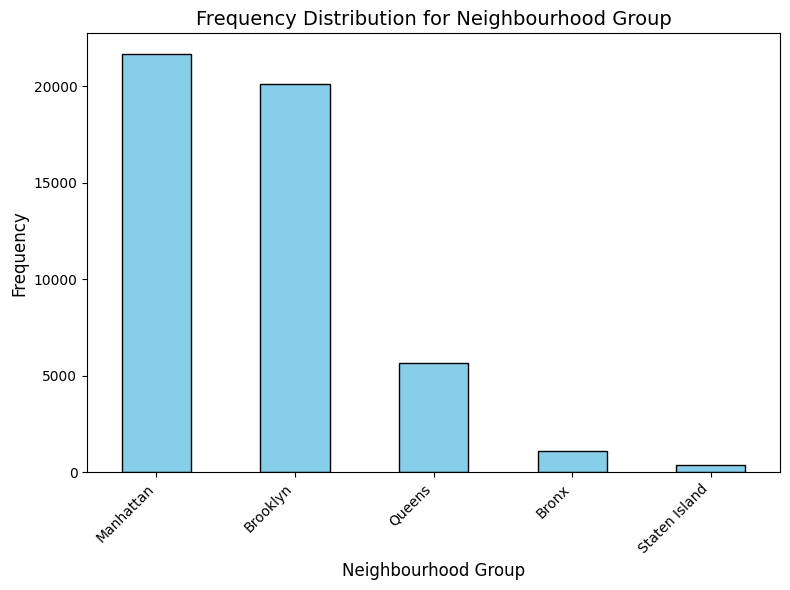

In [ ]:
# Create a bar chart for the 'neighbourhood_group' column
neighbourhood_group_counts = data_raw['neighbourhood_group'].value_counts()

plt.figure(figsize=(8, 6))
neighbourhood_group_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Adding chart details
plt.title('Frequency Distribution for Neighbourhood Group', fontsize=14)
plt.xlabel('Neighbourhood Group', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Display the chart
plt.show()

In [ ]:
bins = range(0, 351, 25)  # Up to 350 to include 327 in the last bin
labels = [f"{i}-{i+24}" for i in bins[:-1]]

# Create a new column with the binned property counts
data_raw['property_count_bin'] = pd.cut(data_raw['calculated_host_listings_count'], bins=bins, labels=labels, right=False)

# Count unique hosts within each bin
host_count_by_bin = data_raw.groupby('property_count_bin')['host_id'].nunique()

# Display the results
print(host_count_by_bin)

property_count_bin
0-24       37423
25-49         22
50-74          4
75-99          4
100-124        2
125-149        0
150-174        0
175-199        0
200-224        0
225-249        1
250-274        0
275-299        0
300-324        0
325-349        1
Name: host_id, dtype: int64


<ipython-input-23-53a9ba223651>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  host_count_by_bin = data_raw.groupby('property_count_bin')['host_id'].nunique()


In [ ]:
# Define bins for property counts (e.g., in intervals of 25, up to a max of 327 properties)
bins = range(0, 351, 25)  # Up to 350 to include 327 in the last bin
labels = [f"{i}-{i+24}" for i in bins[:-1]]

# Bin hosts by their total property count
data_raw['property_count_bin'] = pd.cut(data_raw['calculated_host_listings_count'], bins=bins, labels=labels, right=False)

# Calculate total properties, total reviews, and total reviews per month per property count bin
properties_per_bin = data_raw.groupby('property_count_bin')['id'].count()  # Total properties per bin
reviews_per_bin = data_raw.groupby('property_count_bin')['number_of_reviews'].sum()  # Total reviews (bookings) per bin
reviews_per_month_sum = data_raw.groupby('property_count_bin')['reviews_per_month'].sum()  # Total reviews per month per bin

# Calculate proportions
properties_proportion = properties_per_bin / properties_per_bin.sum()
reviews_proportion = reviews_per_bin / reviews_per_bin.sum()
reviews_per_month_proportion = reviews_per_month_sum / reviews_per_month_sum.sum()

# Create a DataFrame to compare the distributions
comparison_df = pd.DataFrame({
    'Total Properties': properties_per_bin,
    'Total Reviews (Bookings)': reviews_per_bin,
    'Total Reviews Per Month': reviews_per_month_sum,
    'Properties Proportion': properties_proportion,
    'Reviews Proportion': reviews_proportion,
    'Reviews Per Month Proportion': reviews_per_month_proportion
})

# Display the comparison
print(comparison_df)


                    Total Properties  Total Reviews (Bookings)  \
property_count_bin                                               
0-24                           46780                   1131539   
25-49                            743                      3862   
50-74                            219                       489   
75-99                            370                       653   
100-124                          224                       152   
125-149                            0                         0   
150-174                            0                         0   
175-199                            0                         0   
200-224                            0                         0   
225-249                          232                        29   
250-274                            0                         0   
275-299                            0                         0   
300-324                            0                         0   
325-349   

<ipython-input-25-c9dcf87387e9>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  properties_per_bin = data_raw.groupby('property_count_bin')['id'].count()  # Total properties per bin
<ipython-input-25-c9dcf87387e9>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reviews_per_bin = data_raw.groupby('property_count_bin')['number_of_reviews'].sum()  # Total reviews (bookings) per bin
<ipython-input-25-c9dcf87387e9>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the 

This appears to indicate that the majority of the bookings do go hosts with less listings.

In [ ]:
# Define bins including specific bins for 1, 2, 3, 4 properties
bins = [0, 1, 2, 3, 4, 5, 10, 15, 20, 24] + list(range(25, 351, 25))
labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins) - 1)]

# Bin hosts by their total property count
data_raw['property_count_bin'] = pd.cut(data_raw['calculated_host_listings_count'], bins=bins, labels=labels, right=False)

# Calculate total properties, total reviews, and total reviews per month per property count bin
properties_per_bin = data_raw.groupby('property_count_bin')['id'].count()  # Total properties per bin
reviews_per_bin = data_raw.groupby('property_count_bin')['number_of_reviews'].sum()  # Total reviews (bookings) per bin
reviews_per_month_sum = data_raw.groupby('property_count_bin')['reviews_per_month'].sum()  # Total reviews per month per bin

# Calculate proportions
properties_proportion = properties_per_bin / properties_per_bin.sum()
reviews_proportion = reviews_per_bin / reviews_per_bin.sum()
reviews_per_month_proportion = reviews_per_month_sum / reviews_per_month_sum.sum()

# Create a DataFrame to compare the distributions
comparison_df = pd.DataFrame({
    'Total Properties': properties_per_bin,
    'Total Reviews (Bookings)': reviews_per_bin,
    'Total Reviews Per Month': reviews_per_month_sum,
    'Properties Proportion': properties_proportion,
    'Reviews Proportion': reviews_proportion,
    'Reviews Per Month Proportion': reviews_per_month_proportion
})

# Display the comparison
print(comparison_df)

                    Total Properties  Total Reviews (Bookings)  \
property_count_bin                                               
0-0                                0                         0   
1-1                            32303                    659558   
2-2                             6658                    231086   
3-3                             2853                    101679   
4-4                             1440                     53512   
5-9                             2464                     66644   
10-14                            700                     15979   
15-19                            232                      2862   
20-23                            130                       219   
24-24                              0                         0   
25-49                            743                      3862   
50-74                            219                       489   
75-99                            370                       653   
100-124   

<ipython-input-11-9be1e2803ba5>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  properties_per_bin = data_raw.groupby('property_count_bin')['id'].count()  # Total properties per bin
<ipython-input-11-9be1e2803ba5>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reviews_per_bin = data_raw.groupby('property_count_bin')['number_of_reviews'].sum()  # Total reviews (bookings) per bin
<ipython-input-11-9be1e2803ba5>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the 

This section demonstrates that the majority of listings are held by hosts who have less than 5 properties listed.

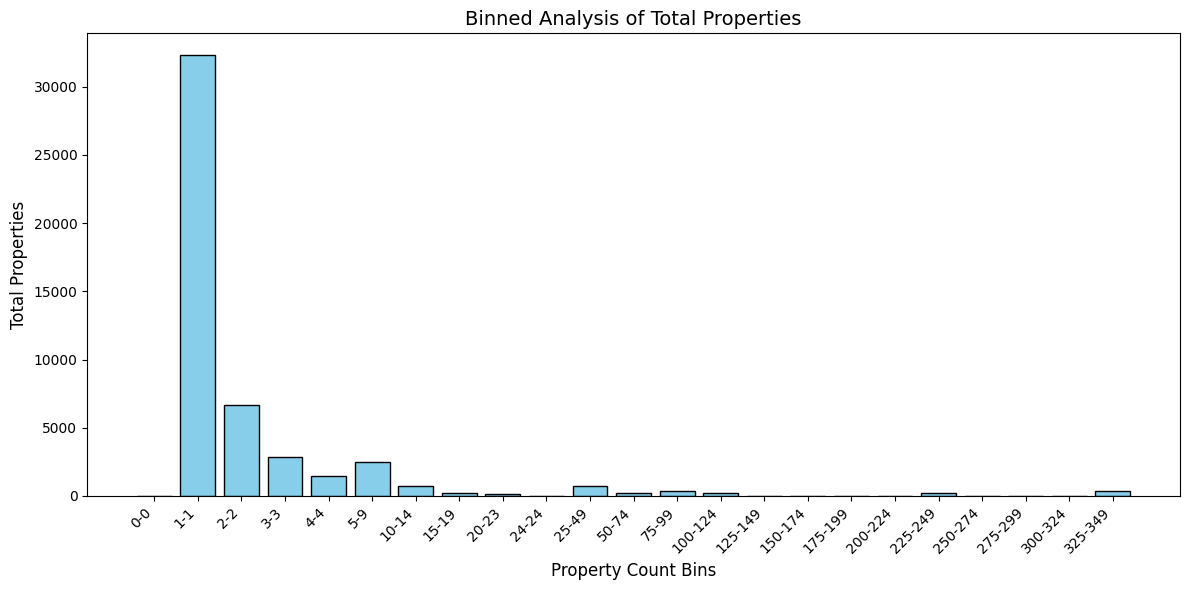

In [ ]:
# Grouped data (properties_per_bin) comes from the earlier step
# Example assumes properties_per_bin is already calculated dynamically

# Plot the bar chart directly from the grouped data
plt.figure(figsize=(12, 6))
plt.bar(properties_per_bin.index.astype(str), properties_per_bin, color='skyblue', edgecolor='black')

# Adding chart details
plt.title('Binned Analysis of Total Properties', fontsize=14)
plt.xlabel('Property Count Bins', fontsize=12)
plt.ylabel('Total Properties', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Display the chart
plt.show()

This notebook is for the UEO Machine Learning Group Project (Group 1).

[Reference CRISPDM]

Structure:
1. Project Overview
2. Notebook Setup
3. Exploratory Data Analysis
4. Pre-Processing/Feature Engineering
5. Model Selection
6. Model Training
7. Model Analysis

In [ ]:
# Select only categorical columns from data_raw and get frequency counts for each category
categorical_data = data_raw.select_dtypes(include='category')
category_counts = {col: categorical_data[col].value_counts() for col in categorical_data.columns}

# Display the results in a structured format
category_counts

{'neighbourhood_group': neighbourhood_group
 Manhattan        21661
 Brooklyn         20104
 Queens            5666
 Bronx             1091
 Staten Island      373
 Name: count, dtype: int64,
 'neighbourhood': neighbourhood
 Williamsburg          3920
 Bedford-Stuyvesant    3714
 Harlem                2658
 Bushwick              2465
 Upper West Side       1971
                       ... 
 Richmondtown             1
 Willowbrook              1
 Fort Wadsworth           1
 New Dorp                 1
 Woodrow                  1
 Name: count, Length: 221, dtype: int64,
 'room_type': room_type
 Entire home/apt    25409
 Private room       22326
 Shared room         1160
 Name: count, dtype: int64}

This shows a frequency count of some of the key categorical data - showing the most popular neighbourhoods, and a split of room type.

Both of these are suitable candidate groups for further investigation and breakdown, especially useful for more targeted pricing strategies.


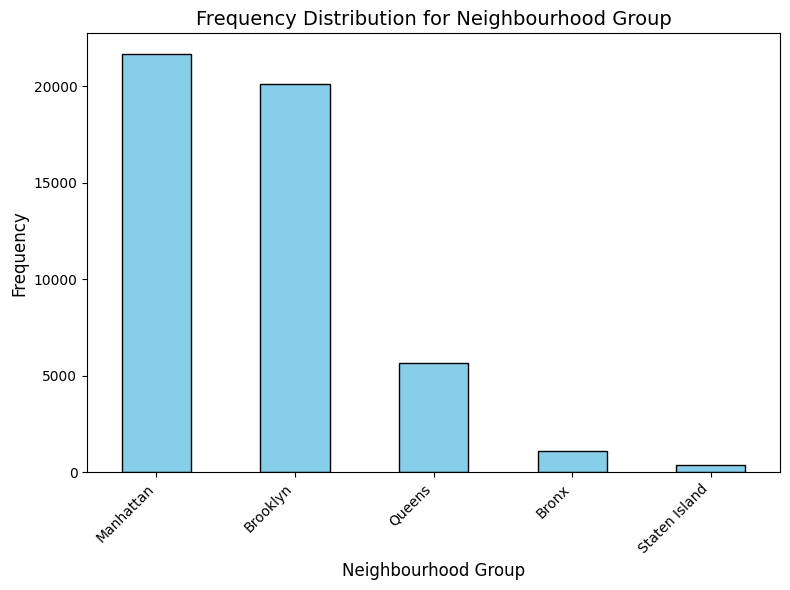

In [ ]:
# Create a bar chart for the 'neighbourhood_group' column
neighbourhood_group_counts = data_raw['neighbourhood_group'].value_counts()

plt.figure(figsize=(8, 6))
neighbourhood_group_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Adding chart details
plt.title('Frequency Distribution for Neighbourhood Group', fontsize=14)
plt.xlabel('Neighbourhood Group', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Display the chart
plt.show()

In [ ]:
bins = range(0, 351, 25)  # Up to 350 to include 327 in the last bin
labels = [f"{i}-{i+24}" for i in bins[:-1]]

# Create a new column with the binned property counts
data_raw['property_count_bin'] = pd.cut(data_raw['calculated_host_listings_count'], bins=bins, labels=labels, right=False)

# Count unique hosts within each bin
host_count_by_bin = data_raw.groupby('property_count_bin')['host_id'].nunique()

# Display the results
print(host_count_by_bin)

property_count_bin
0-24       37423
25-49         22
50-74          4
75-99          4
100-124        2
125-149        0
150-174        0
175-199        0
200-224        0
225-249        1
250-274        0
275-299        0
300-324        0
325-349        1
Name: host_id, dtype: int64


<ipython-input-23-53a9ba223651>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  host_count_by_bin = data_raw.groupby('property_count_bin')['host_id'].nunique()


In [ ]:
# Define bins for property counts (e.g., in intervals of 25, up to a max of 327 properties)
bins = range(0, 351, 25)  # Up to 350 to include 327 in the last bin
labels = [f"{i}-{i+24}" for i in bins[:-1]]

# Bin hosts by their total property count
data_raw['property_count_bin'] = pd.cut(data_raw['calculated_host_listings_count'], bins=bins, labels=labels, right=False)

# Calculate total properties, total reviews, and total reviews per month per property count bin
properties_per_bin = data_raw.groupby('property_count_bin')['id'].count()  # Total properties per bin
reviews_per_bin = data_raw.groupby('property_count_bin')['number_of_reviews'].sum()  # Total reviews (bookings) per bin
reviews_per_month_sum = data_raw.groupby('property_count_bin')['reviews_per_month'].sum()  # Total reviews per month per bin

# Calculate proportions
properties_proportion = properties_per_bin / properties_per_bin.sum()
reviews_proportion = reviews_per_bin / reviews_per_bin.sum()
reviews_per_month_proportion = reviews_per_month_sum / reviews_per_month_sum.sum()

# Create a DataFrame to compare the distributions
comparison_df = pd.DataFrame({
    'Total Properties': properties_per_bin,
    'Total Reviews (Bookings)': reviews_per_bin,
    'Total Reviews Per Month': reviews_per_month_sum,
    'Properties Proportion': properties_proportion,
    'Reviews Proportion': reviews_proportion,
    'Reviews Per Month Proportion': reviews_per_month_proportion
})

# Display the comparison
print(comparison_df)


                    Total Properties  Total Reviews (Bookings)  \
property_count_bin                                               
0-24                           46780                   1131539   
25-49                            743                      3862   
50-74                            219                       489   
75-99                            370                       653   
100-124                          224                       152   
125-149                            0                         0   
150-174                            0                         0   
175-199                            0                         0   
200-224                            0                         0   
225-249                          232                        29   
250-274                            0                         0   
275-299                            0                         0   
300-324                            0                         0   
325-349   

<ipython-input-25-c9dcf87387e9>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  properties_per_bin = data_raw.groupby('property_count_bin')['id'].count()  # Total properties per bin
<ipython-input-25-c9dcf87387e9>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reviews_per_bin = data_raw.groupby('property_count_bin')['number_of_reviews'].sum()  # Total reviews (bookings) per bin
<ipython-input-25-c9dcf87387e9>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the 

This appears to indicate that the majority of the bookings do go hosts with less listings.

In [ ]:
# Define bins including specific bins for 1, 2, 3, 4 properties
bins = [0, 1, 2, 3, 4, 5, 10, 15, 20, 24] + list(range(25, 351, 25))
labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins) - 1)]

# Bin hosts by their total property count
data_raw['property_count_bin'] = pd.cut(data_raw['calculated_host_listings_count'], bins=bins, labels=labels, right=False)

# Calculate total properties, total reviews, and total reviews per month per property count bin
properties_per_bin = data_raw.groupby('property_count_bin')['id'].count()  # Total properties per bin
reviews_per_bin = data_raw.groupby('property_count_bin')['number_of_reviews'].sum()  # Total reviews (bookings) per bin
reviews_per_month_sum = data_raw.groupby('property_count_bin')['reviews_per_month'].sum()  # Total reviews per month per bin

# Calculate proportions
properties_proportion = properties_per_bin / properties_per_bin.sum()
reviews_proportion = reviews_per_bin / reviews_per_bin.sum()
reviews_per_month_proportion = reviews_per_month_sum / reviews_per_month_sum.sum()

# Create a DataFrame to compare the distributions
comparison_df = pd.DataFrame({
    'Total Properties': properties_per_bin,
    'Total Reviews (Bookings)': reviews_per_bin,
    'Total Reviews Per Month': reviews_per_month_sum,
    'Properties Proportion': properties_proportion,
    'Reviews Proportion': reviews_proportion,
    'Reviews Per Month Proportion': reviews_per_month_proportion
})

# Display the comparison
print(comparison_df)

                    Total Properties  Total Reviews (Bookings)  \
property_count_bin                                               
0-0                                0                         0   
1-1                            32303                    659558   
2-2                             6658                    231086   
3-3                             2853                    101679   
4-4                             1440                     53512   
5-9                             2464                     66644   
10-14                            700                     15979   
15-19                            232                      2862   
20-23                            130                       219   
24-24                              0                         0   
25-49                            743                      3862   
50-74                            219                       489   
75-99                            370                       653   
100-124   

<ipython-input-11-9be1e2803ba5>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  properties_per_bin = data_raw.groupby('property_count_bin')['id'].count()  # Total properties per bin
<ipython-input-11-9be1e2803ba5>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reviews_per_bin = data_raw.groupby('property_count_bin')['number_of_reviews'].sum()  # Total reviews (bookings) per bin
<ipython-input-11-9be1e2803ba5>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the 

This section demonstrates that the majority of listings are held by hosts who have less than 5 properties listed.

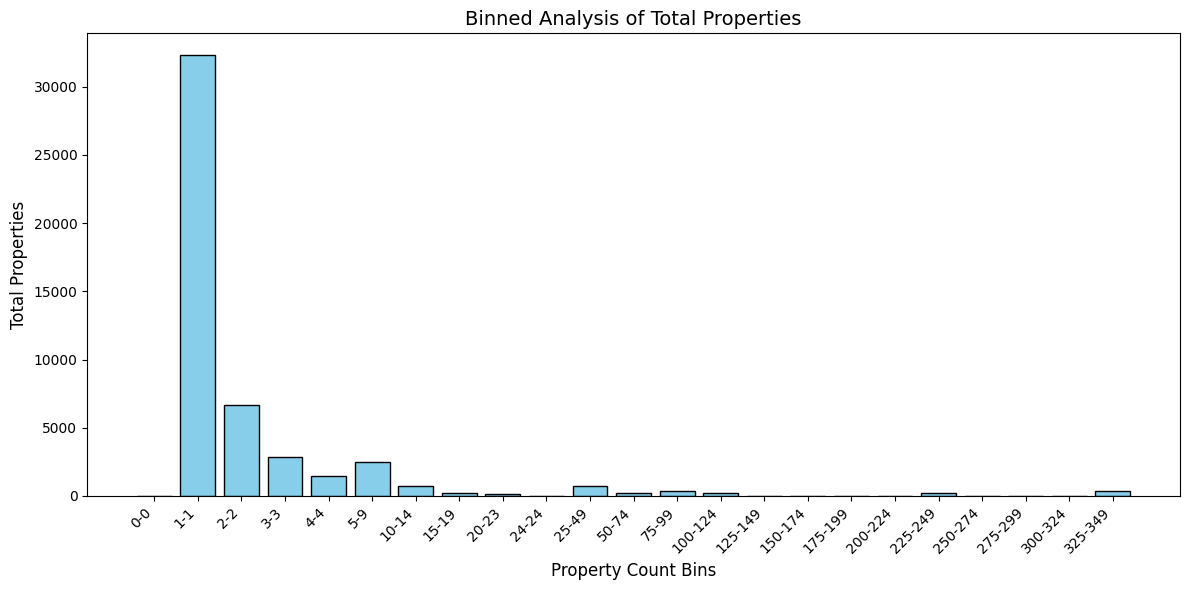

In [ ]:
# Grouped data (properties_per_bin) comes from the earlier step
# Example assumes properties_per_bin is already calculated dynamically

# Plot the bar chart directly from the grouped data
plt.figure(figsize=(12, 6))
plt.bar(properties_per_bin.index.astype(str), properties_per_bin, color='skyblue', edgecolor='black')

# Adding chart details
plt.title('Binned Analysis of Total Properties', fontsize=14)
plt.xlabel('Property Count Bins', fontsize=12)
plt.ylabel('Total Properties', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Display the chart
plt.show()

# 4. Minimum Nights

In [ ]:
# Load the dataset
data = pd.read_csv("AB_NYC_2019.csv")
# Drop rows with missing values in critical columns
data = data.dropna(subset=['price', 'minimum_nights', 'room_type', 'availability_365', 'reviews_per_month', 'neighbourhood_group'])


Average Price: 142.32
Standard Deviation: 196.95


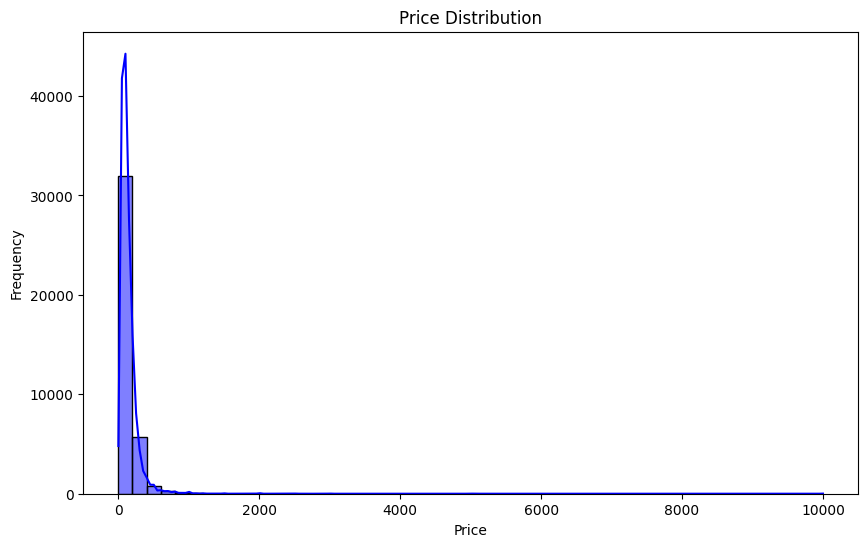

In [ ]:
# 1. Price Variation
average_price = data['price'].mean()
std_dev_price = data['price'].std()

print("Average Price:", round(average_price, 2))
print("Standard Deviation:", round(std_dev_price, 2))

# Plotting Price Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['price'], bins=50, kde=True, color='blue')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


Minimum Nights Range: (np.int64(1), np.int64(1250))
Median Minimum Nights: 2.0


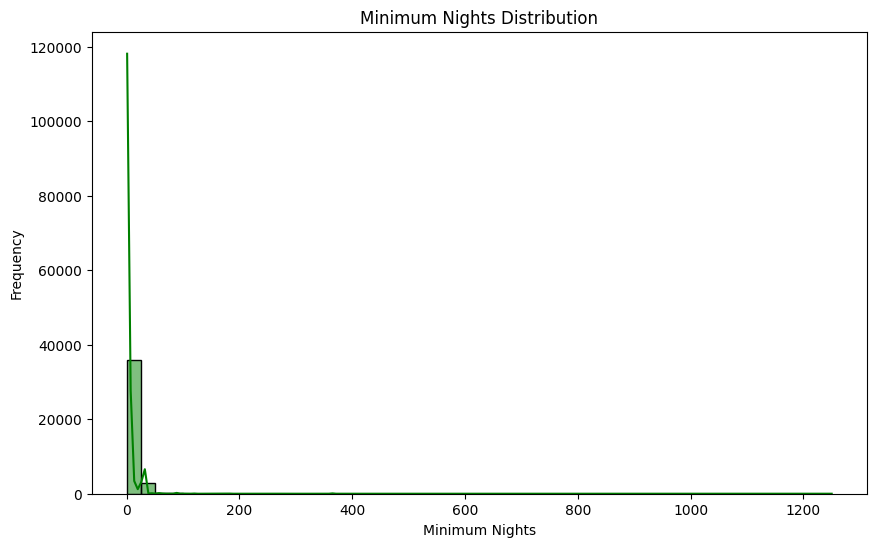

In [ ]:

# 2. Minimum Nights Analysis
min_nights_range = (data['minimum_nights'].min(), data['minimum_nights'].max())
median_min_nights = data['minimum_nights'].median()

print("Minimum Nights Range:", min_nights_range)
print("Median Minimum Nights:", median_min_nights)

# Plotting Minimum Nights Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['minimum_nights'], bins=50, kde=True, color='green')
plt.title('Minimum Nights Distribution')
plt.xlabel('Minimum Nights')
plt.ylabel('Frequency')
plt.show()


Correlation Coefficient between Price and Minimum Nights: 0.026


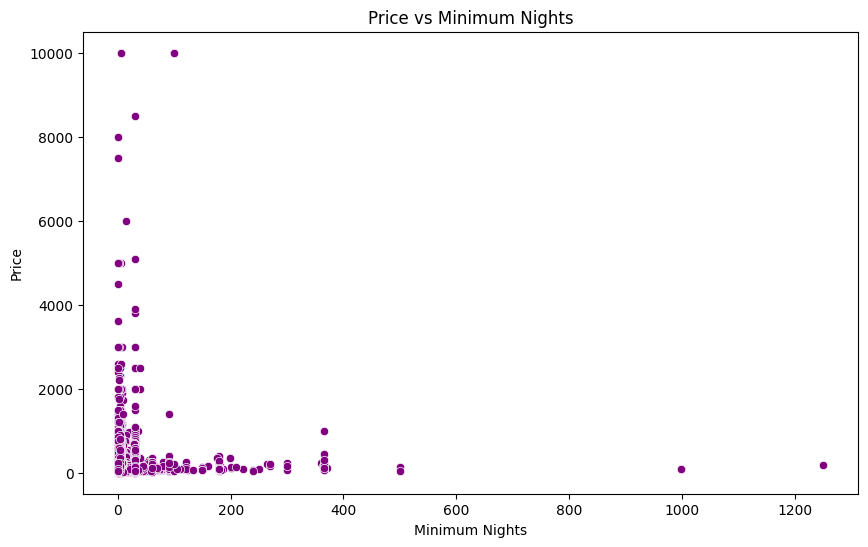

In [ ]:
# 3. Correlation Between Price and Minimum Nights
correlation, p_value = pearsonr(data['price'], data['minimum_nights'])

print("Correlation Coefficient between Price and Minimum Nights:", round(correlation, 3))

# Plotting Correlation between Price and Minimum Nights
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['minimum_nights'], y=data['price'], color='purple')
plt.title('Price vs Minimum Nights')
plt.xlabel('Minimum Nights')
plt.ylabel('Price')
plt.show()



Price Statistics by Room Type:
                    mean  median     std
room_type                              
Entire home/apt  196.29   151.0  223.65
Private room      83.98    70.0  142.24
Shared room       63.21    45.0   95.19


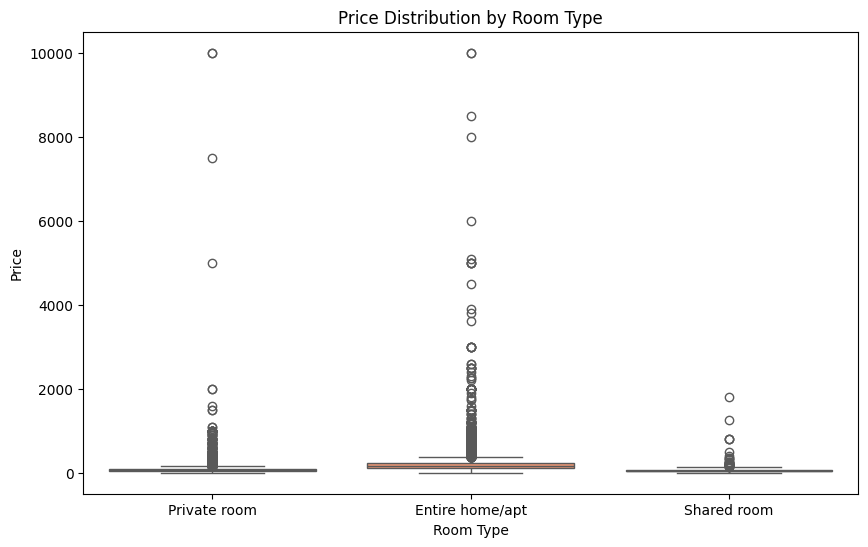

In [ ]:
# 4. Price Statistics by Room Type
price_stats_by_room_type = data.groupby('room_type')['price'].agg(['mean', 'median', 'std']).round(2)
print("\nPrice Statistics by Room Type:\n", price_stats_by_room_type)

# Plotting Price Statistics by Room Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='price', data=data, hue='room_type', palette='Set2', legend=False)
plt.title('Price Distribution by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.show()



Average Availability by Room Type:
 room_type
Entire home/apt    111.37
Private room       116.47
Shared room        166.00
Name: availability_365, dtype: float64


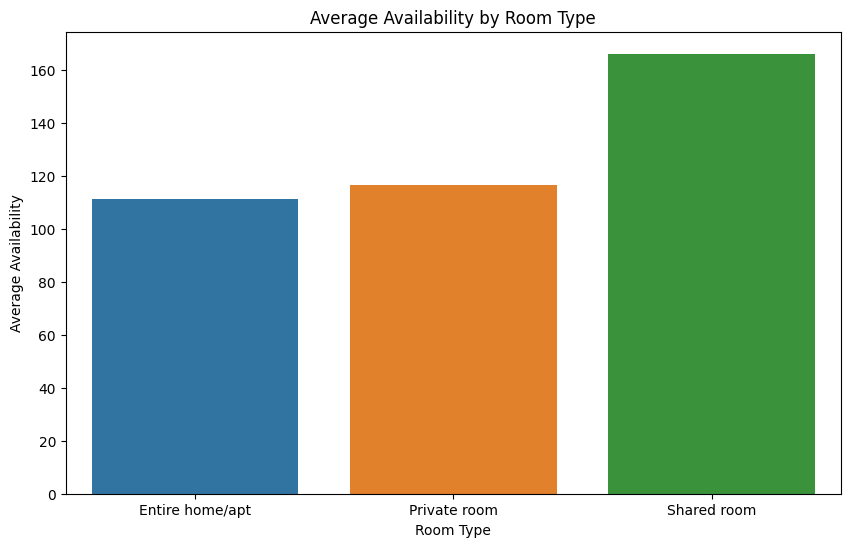

In [ ]:
# 5. Average Availability by Room Type
average_availability_by_room_type = data.groupby('room_type')['availability_365'].mean().round(2)
print("\nAverage Availability by Room Type:\n", average_availability_by_room_type)

# Plotting Average Availability by Room Type (with adjusted hue)
plt.figure(figsize=(10, 6))
sns.barplot(x=average_availability_by_room_type.index, y=average_availability_by_room_type.values, hue=average_availability_by_room_type.index)
plt.title('Average Availability by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Average Availability')
plt.show()




Average Minimum Nights by Room Type:
 room_type
Entire home/apt    7.08
Private room       4.54
Shared room        4.40
Name: minimum_nights, dtype: float64


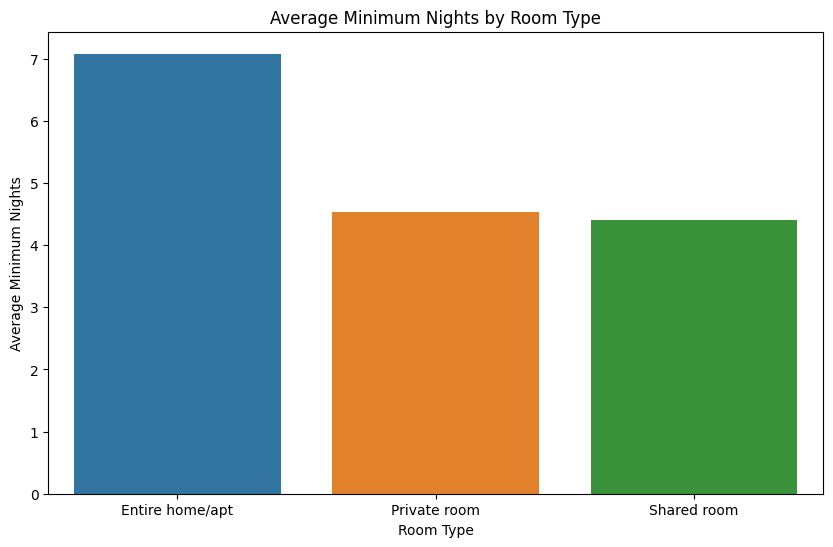

In [ ]:
# 6. Average Minimum Nights by Room Type
average_min_nights_by_room_type = data.groupby('room_type')['minimum_nights'].mean().round(2)
print("\nAverage Minimum Nights by Room Type:\n", average_min_nights_by_room_type)

# Plotting Average Minimum Nights by Room Type (with adjusted hue)
plt.figure(figsize=(10, 6))
sns.barplot(x=average_min_nights_by_room_type.index, y=average_min_nights_by_room_type.values, hue=average_min_nights_by_room_type.index)
plt.title('Average Minimum Nights by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Average Minimum Nights')
plt.show()



Average Reviews per Month by Room Type:
 room_type
Entire home/apt    1.31
Private room       1.45
Shared room        1.47
Name: reviews_per_month, dtype: float64


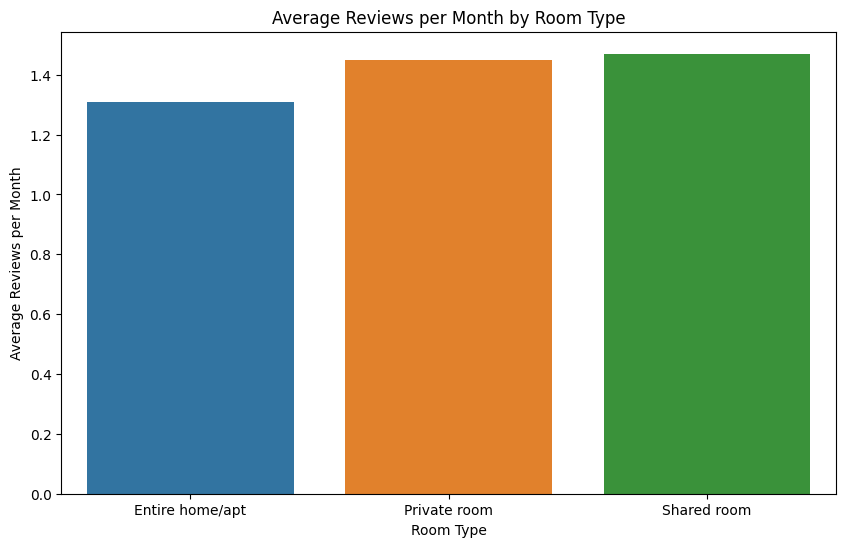

In [ ]:
# 7. Average Reviews per Month by Room Type
average_reviews_by_room_type = data.groupby('room_type')['reviews_per_month'].mean().round(2)
print("\nAverage Reviews per Month by Room Type:\n", average_reviews_by_room_type)

# Plotting Average Reviews per Month by Room Type (with adjusted hue)
plt.figure(figsize=(10, 6))
sns.barplot(x=average_reviews_by_room_type.index, y=average_reviews_by_room_type.values, hue=average_reviews_by_room_type.index)
plt.title('Average Reviews per Month by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Average Reviews per Month')
plt.show()


In [ ]:
# 8. ANOVA Test for Price Differences among Room Types
room_type_groups = [data['price'][data['room_type'] == rt] for rt in data['room_type'].unique()]
anova_result = f_oneway(*room_type_groups)

print("\nANOVA Test Result (p-value):", round(anova_result.pvalue, 5))



ANOVA Test Result (p-value): 0.0


**Summary:**

The analysis shows considerable variation in Airbnb listing prices in New York, with an average price of \$142.32
and a standard deviation of \$196.95. Minimum stay requirements tend to be low, with a
median of 2 nights, although some listings do have longer minimums. There is a weak correlation (0.026)
between price and minimum nights, suggesting that this factor has little effect on pricing.
In contrast, room type plays a significant role in determining prices: Entire Home/Apt listings
command the highest average price, while Private and Shared Rooms are more budget-friendly.
Shared Rooms also have the highest availability and comparable engagement levels (in terms of reviews)
to Private Rooms. An ANOVA test indicates notable price differences among room types, implying that room
type and location are more critical to pricing than minimum night requirements.
of \$142.32 and a standard deviation of \$196.95. Minimum stay requirements tend to be low, with a
median of 2 nights, although some listings do have longer minimums. There is a weak correlation (0.026)
between price and minimum nights, suggesting that this factor has little effect on pricing.
In contrast, room type plays a significant role in determining prices: Entire Home/Apt listings
command the highest average price, while Private and Shared Rooms are more budget-friendly.
Shared Rooms also have the highest availability and comparable engagement levels (in terms of reviews)
to Private Rooms. An ANOVA test indicates notable price differences among room types, implying that room
type and location are more critical to pricing than minimum night requirements.


# 5. Room Type

**Data Analysis Comparing room_type and price from AB_NYC_2019**

In [ ]:
# Cleaning up dataset for analysis

data_new = pd.read_csv("AB_NYC_2019.csv")

data_new['room_type'] = data_new['room_type'].str.strip()
data_new['room_type'] = data_new['room_type'].str.lower()

data_new.isnull().sum()
data_new = data_new.dropna(subset=['price', 'room_type'])

room_type_price_stats = data_new.groupby('room_type')['price'].describe()
room_type_price_stats

count        mean         std  min    25%    50%    75%  \
room_type                                                                    
entire home/apt  25409.0  211.794246  284.041611  0.0  120.0  160.0  229.0   
private room     22326.0   89.780973  160.205262  0.0   50.0   70.0   95.0   
shared room       1160.0   70.127586  101.725252  0.0   33.0   45.0   75.0   

                     max  
room_type                 
entire home/apt  10000.0  
private room     10000.0  
shared room       1800.0

In [ ]:
# Statistical Analysis of room_type and price

data_new = pd.read_csv("AB_NYC_2019.csv")

print(data_new[['room_type', 'price']].isnull().sum())

room_type_price_stats = data_new.groupby('room_type')['price'].describe()

print(room_type_price_stats)


room_type    0
price        0
dtype: int64
                   count        mean         std  min    25%    50%    75%  \
room_type                                                                    
Entire home/apt  25409.0  211.794246  284.041611  0.0  120.0  160.0  229.0   
Private room     22326.0   89.780973  160.205262  0.0   50.0   70.0   95.0   
Shared room       1160.0   70.127586  101.725252  0.0   33.0   45.0   75.0   

                     max  
room_type                 
Entire home/apt  10000.0  
Private room     10000.0  
Shared room       1800.0  


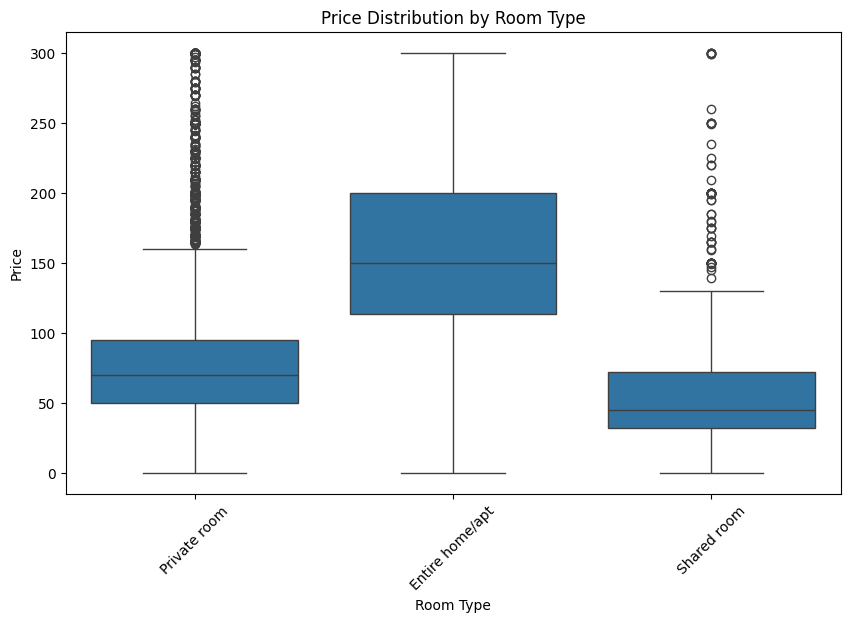

In [ ]:
# Box plot to compare price distribution by room_type

data_new = data_new[data_new['price'] <= 300]
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='price', data=data_new)
plt.title('Price Distribution by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()



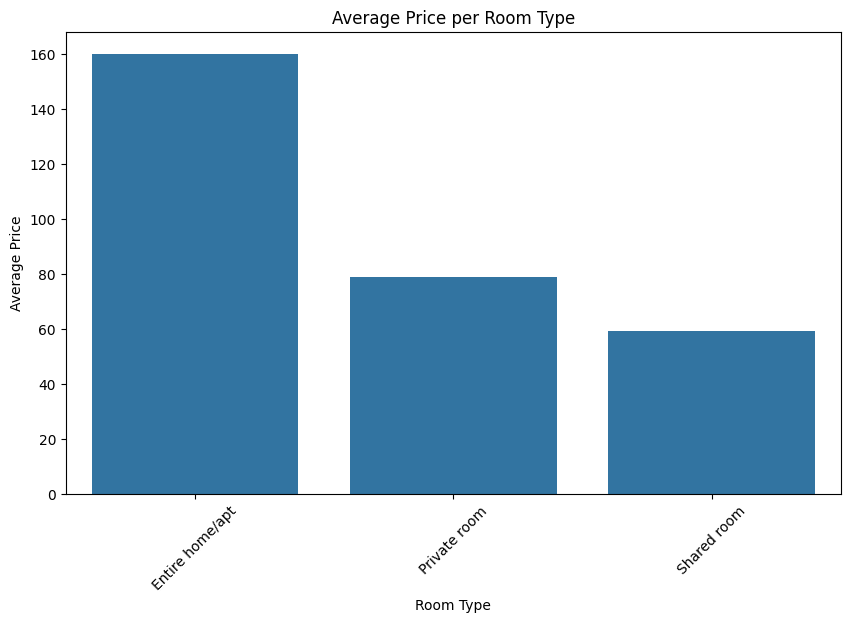

In [ ]:
# Bar plot for average price per room type

avg_price_per_room = data_new.groupby('room_type')['price'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_price_per_room.index, y=avg_price_per_room.values)
plt.title('Average Price per Room Type')
plt.xlabel('Room Type')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

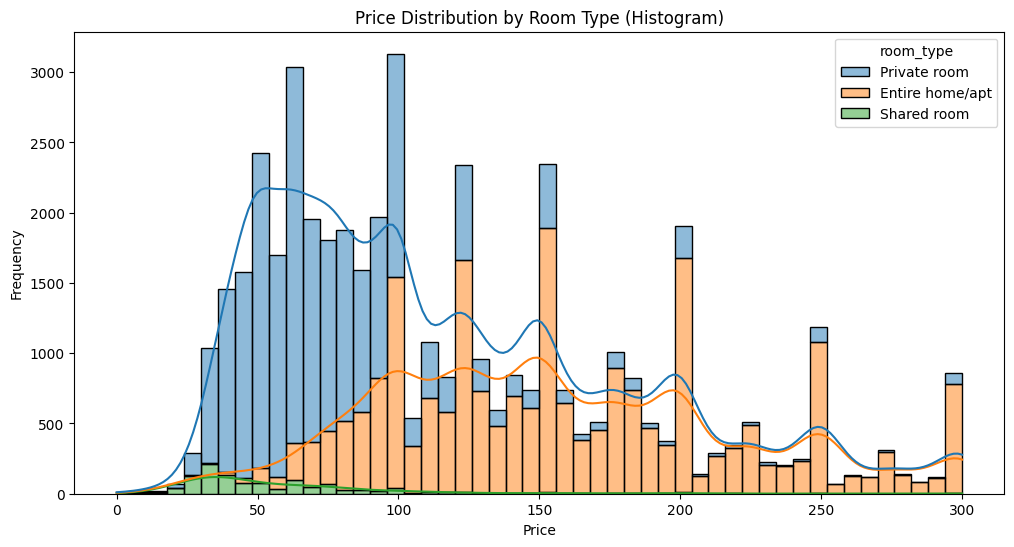

In [ ]:
# Histogram of prices by room type

plt.figure(figsize=(12, 6))
sns.histplot(data=data_new, x='price', hue='room_type', kde=True, multiple="stack", bins=50)
plt.title('Price Distribution by Room Type (Histogram)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


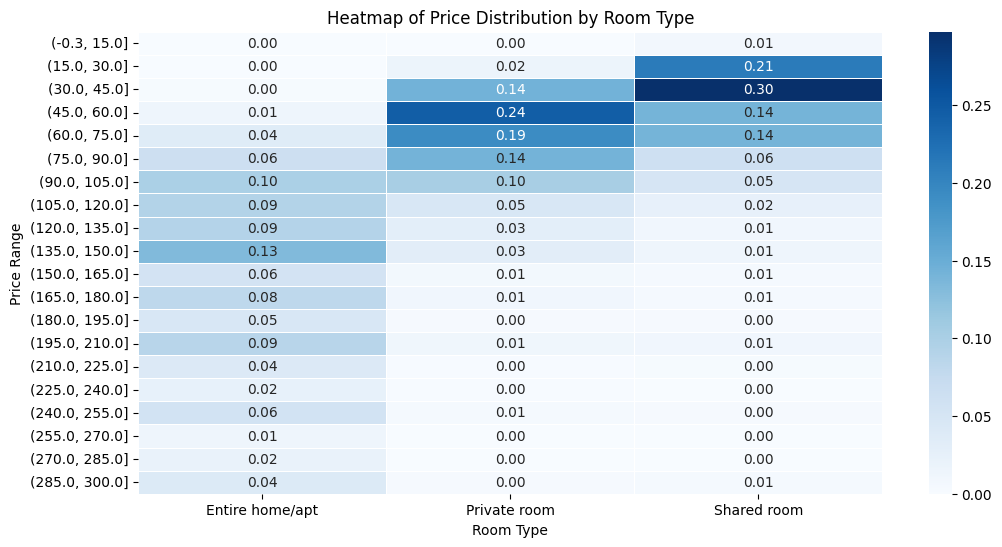

In [ ]:
# Pivot table to create a heatmap of price distribution by room type and price bin

price_bins = pd.cut(data_new['price'], bins=20)

price_bin_room_type = pd.crosstab(price_bins, data_new['room_type'], normalize='columns')

plt.figure(figsize=(12, 6))
sns.heatmap(price_bin_room_type, cmap='Blues', annot=True, fmt='.2f', linewidths=.5)
plt.title('Heatmap of Price Distribution by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price Range')
plt.show()


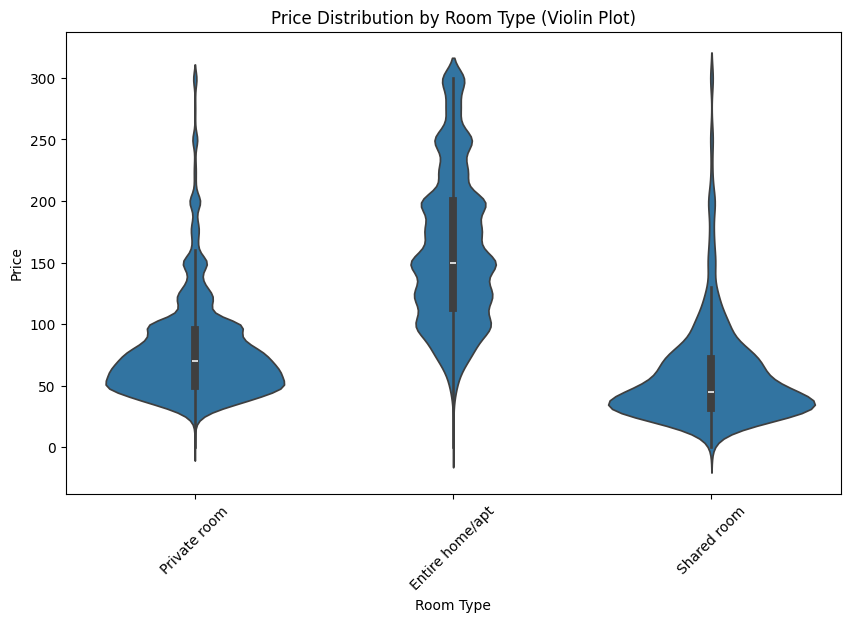

In [ ]:
# Violin plot for price distribution by room type

plt.figure(figsize=(10, 6))
sns.violinplot(x='room_type', y='price', data=data_new)
plt.title('Price Distribution by Room Type (Violin Plot)')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()


               mean  count
cluster                   
0         62.065581  20143
1        222.849421   9583
2        126.528396  15812


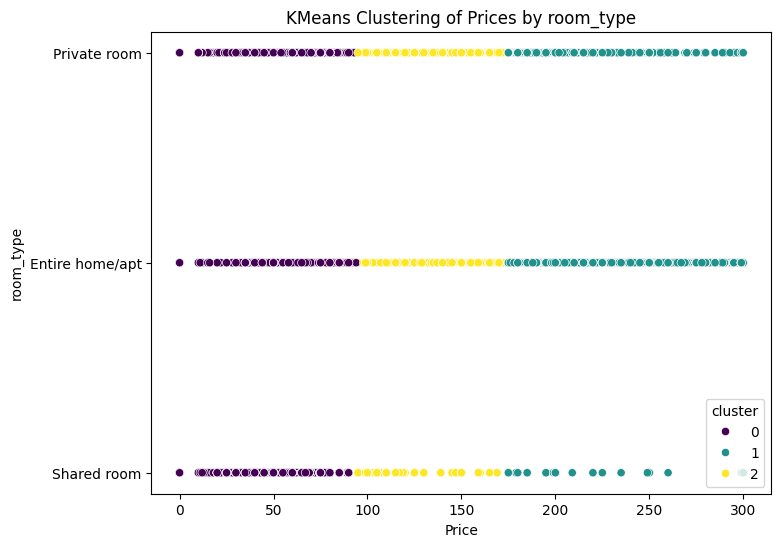

In [ ]:
# KMeans Clustering

X = data_new[['price']]

kmeans = KMeans(n_clusters=3, random_state=0)
data_new['cluster'] = kmeans.fit_predict(X)

cluster_summary = data_new.groupby('cluster')['price'].agg(['mean', 'count'])
print(cluster_summary)

plt.figure(figsize=(8, 6))
sns.scatterplot(x='price', y='room_type', hue='cluster', data=data_new, palette='viridis')
plt.title('KMeans Clustering of Prices by room_type')
plt.xlabel('Price')
plt.ylabel('room_type')
plt.show()

# 6. Geographic Location and Neighbourhood

**Rename Dataset:**

In [ ]:
airbnb_data = pd.read_csv("AB_NYC_2019.csv")

**We first check for missing values:**

In [ ]:
# How many rows has the dataset?
print(len(airbnb_data))

# Search for missing values:
na_counts = airbnb_data.isna().sum()
print(na_counts)

48895
id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64


**Next, we aim at visualising the price per geographic region within New York using the Geopandas library together with matblotlib and seaborn:**

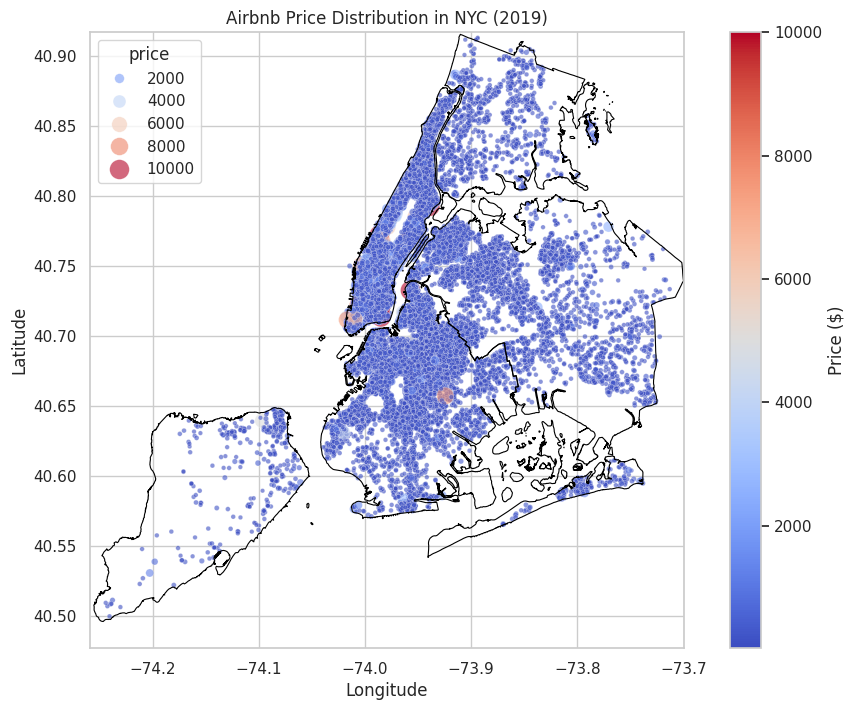

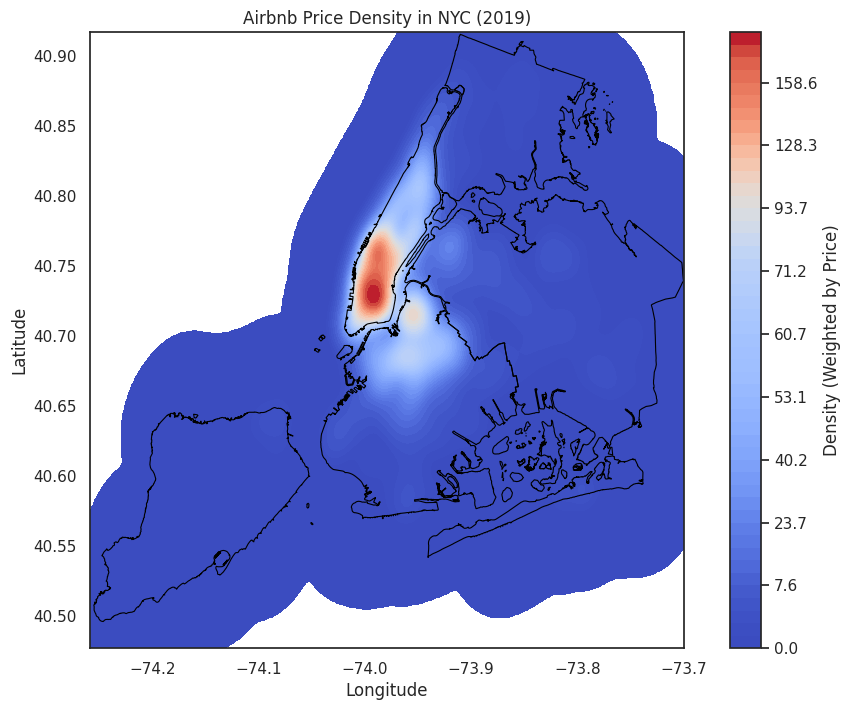

In [ ]:
# Use geopandas to fetch NYC boundaries
# Changed URL to download GeoJSON file directly
nyc_boundaries = gpd.read_file("https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=GeoJSON")

# Check the coordinate reference system (CRS) and reproject if needed
nyc_boundaries = nyc_boundaries.to_crs("EPSG:4326")  # Reproject to match GPS coordinates (latitude, longitude)

# Load Airbnb NYC 2019 data
airbnb_data = pd.read_csv("AB_NYC_2019.csv")

# Drop rows with missing or zero values in key columns
airbnb_data = airbnb_data.dropna(subset=['latitude', 'longitude', 'price'])
airbnb_data = airbnb_data[airbnb_data['price'] > 0]

# Set the plot limits based on NYC bounds
nyc_bounds = {
    "longitude": (-74.259, -73.7),
    "latitude": (40.477, 40.917)
}

# Set up the scatter plot with NYC boundaries
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Create a scatter plot with latitude and longitude, color-coded by price
scatter = sns.scatterplot(
    x=airbnb_data['longitude'],
    y=airbnb_data['latitude'],
    hue=airbnb_data['price'],
    palette="coolwarm",
    size=airbnb_data['price'],
    sizes=(10, 200),
    alpha=0.6,
    marker="o"
)

# Overlay NYC boundaries
nyc_boundaries.plot(ax=plt.gca(), edgecolor="black", facecolor="none", linewidth=0.8)

# Add titles and labels
plt.title("Airbnb Price Distribution in NYC (2019)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Create a colorbar
norm = plt.Normalize(vmin=airbnb_data['price'].min(), vmax=airbnb_data['price'].max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=scatter.axes, label="Price ($)")

plt.xlim(nyc_bounds["longitude"])
plt.ylim(nyc_bounds["latitude"])

plt.show()

# Set up the KDE plot with NYC boundaries
plt.figure(figsize=(12, 8))
sns.set(style="white")

# Create a KDE plot, weighted by price and with color map
ax = sns.kdeplot(
    x=airbnb_data['longitude'],
    y=airbnb_data['latitude'],
    weights=airbnb_data['price'],
    cmap="coolwarm",
    fill=True,
    thresh=0,
    levels=50
)

# Overlay NYC boundaries
nyc_boundaries.plot(ax=plt.gca(), edgecolor="black", facecolor="none", linewidth=0.8)

# Manually add the color bar for the density plot
mappable = ax.collections[0]  # Adjusted to get the correct collection from the KDE plot
plt.colorbar(mappable, ax=ax, label="Density (Weighted by Price)")

# Add titles and labels
plt.title("Airbnb Price Density in NYC (2019)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Set plot limits to NYC bounds
plt.xlim(nyc_bounds["longitude"])
plt.ylim(nyc_bounds["latitude"])

plt.show()

**Interpretation:**

We see that there are especially many listings on AirBnB for Manhattan and Brooklyn. The Bronx and Queens have a moderate number of listings while in Staten Island only very few objects are listed.

Most listed object fall in approximately the same price range with only minor deviations upwards in some parts of Manhattan and Brooklyn.

The information gained in this analysis can be used to implement a well-informed pricing strategy. Objects outside of Manhattan and Brooklyn could target even lower prices to present an interesting alternative on the market. This way tourists with smaller budgets could be targeted and an additional customer group can be addressed.

**Next, we recreate the same visualisation but with a new binned price variable to split the prices into categories with distinct colours**:

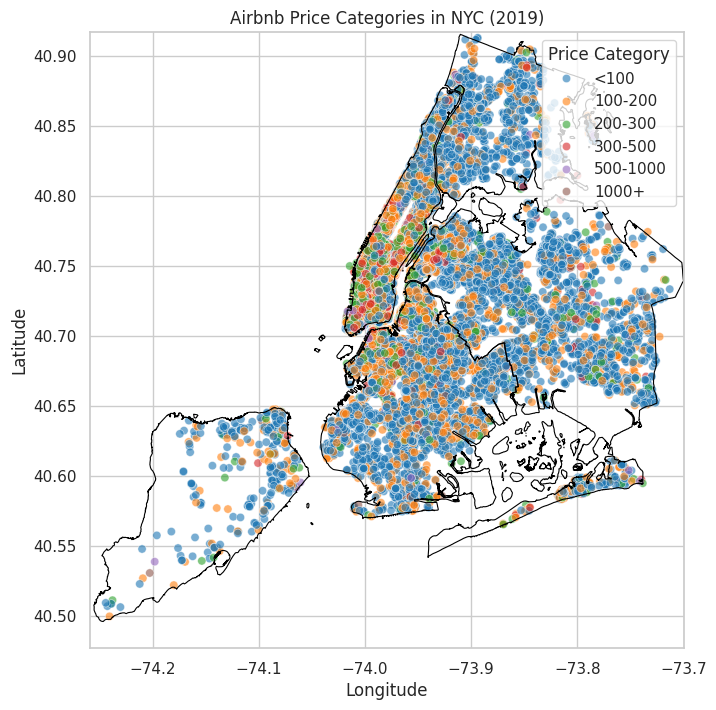

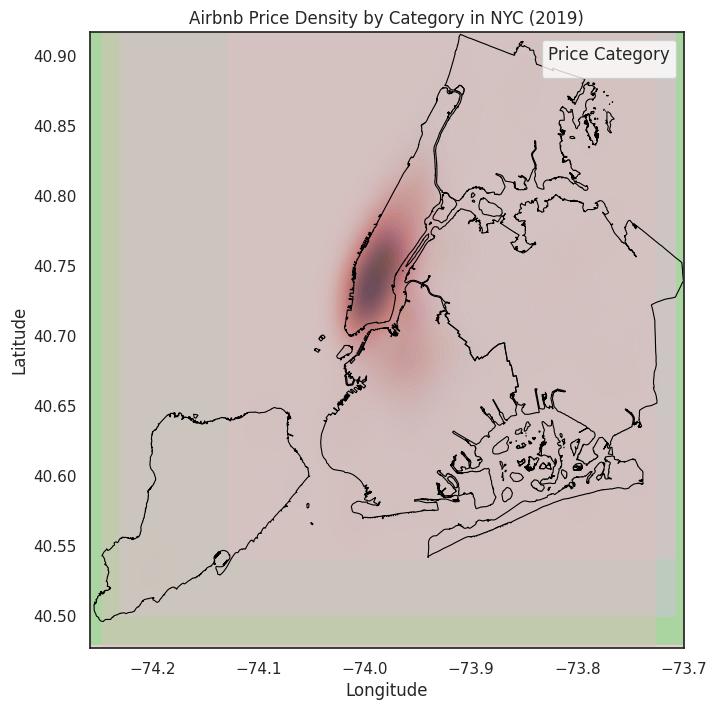

In [ ]:
# Use geopandas to fetch NYC boundaries
# Changed URL to download GeoJSON file directly
nyc_boundaries = gpd.read_file("https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=GeoJSON")

# Check the coordinate reference system (CRS) and reproject if needed
nyc_boundaries = nyc_boundaries.to_crs("EPSG:4326")  # Reproject to match GPS coordinates (latitude, longitude)

# Load Airbnb NYC 2019 data
airbnb_data = pd.read_csv("AB_NYC_2019.csv")

# Drop rows with missing or zero values in key columns
airbnb_data = airbnb_data.dropna(subset=['latitude', 'longitude', 'price'])
airbnb_data = airbnb_data[airbnb_data['price'] > 0]

# Create a binned price variable
bins = [0, 100, 200, 300, 500, 1000, float('inf')]  # Define bins
labels = ['<100', '100-200', '200-300', '300-500', '500-1000', '1000+']  # Define labels
airbnb_data['price_category'] = pd.cut(airbnb_data['price'], bins=bins, labels=labels, include_lowest=True)

# Define a custom color palette with distinct colors
custom_palette = {
    '<100': '#1f77b4',    # Blue
    '100-200': '#ff7f0e', # Orange
    '200-300': '#2ca02c', # Green
    '300-500': '#d62728', # Red
    '500-1000': '#9467bd', # Purple
    '1000+': '#8c564b'    # Brown
}

# Set the plot limits based on NYC bounds
nyc_bounds = {
    "longitude": (-74.259, -73.7),
    "latitude": (40.477, 40.917)
}

# Set up the scatter plot with NYC boundaries
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Create a scatter plot with latitude and longitude, color-coded by price category
scatter = sns.scatterplot(
    x=airbnb_data['longitude'],
    y=airbnb_data['latitude'],
    hue=airbnb_data['price_category'],
    palette=custom_palette,  # Use the custom color palette
    alpha=0.6,
    marker="o"
)

# Overlay NYC boundaries
nyc_boundaries.plot(ax=plt.gca(), edgecolor="black", facecolor="none", linewidth=0.8)

# Add titles and labels
plt.title("Airbnb Price Categories in NYC (2019)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Add a legend for price categories
plt.legend(title="Price Category", loc='upper right')

plt.xlim(nyc_bounds["longitude"])
plt.ylim(nyc_bounds["latitude"])

plt.show()

# Set up the KDE plot with NYC boundaries
plt.figure(figsize=(12, 8))
sns.set(style="white")

# Create a KDE plot, using price category to filter if needed (use all for simplicity here)
for category, color in custom_palette.items():
    subset = airbnb_data[airbnb_data['price_category'] == category]
    sns.kdeplot(
        x=subset['longitude'],
        y=subset['latitude'],
        color=color,  # Use the custom color for each category
        fill=True,
        alpha=0.5,
        thresh=0,
        levels=50,
        label=category
    )

# Overlay NYC boundaries
nyc_boundaries.plot(ax=plt.gca(), edgecolor="black", facecolor="none", linewidth=0.8)

# Add titles and labels
plt.title("Airbnb Price Density by Category in NYC (2019)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Add a legend for the KDE plot
plt.legend(title="Price Category", loc='upper right')

# Set plot limits to NYC bounds
plt.xlim(nyc_bounds["longitude"])
plt.ylim(nyc_bounds["latitude"])

plt.show()

**Next, we just include listings that have reviews to exclude listings that maybe never get booked:**

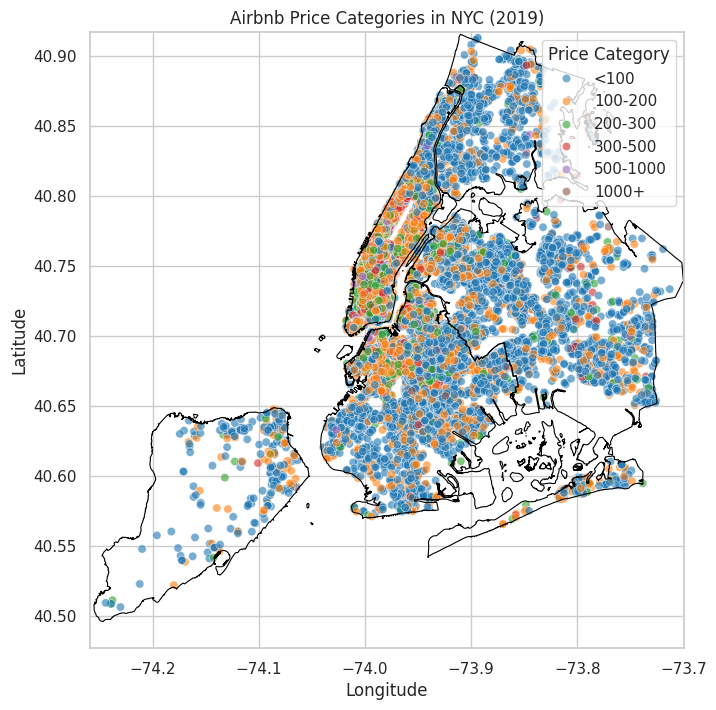

In [ ]:
# Use geopandas to fetch NYC boundaries
# Changed URL to download GeoJSON file directly
nyc_boundaries = gpd.read_file("https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=GeoJSON")

# Check the coordinate reference system (CRS) and reproject if needed
nyc_boundaries = nyc_boundaries.to_crs("EPSG:4326")  # Reproject to match GPS coordinates (latitude, longitude)

# Load Airbnb NYC 2019 data
airbnb_data = pd.read_csv("AB_NYC_2019.csv")

# Drop rows with missing or zero values in key columns
airbnb_data = airbnb_data.dropna(subset=['latitude', 'longitude', 'price', 'number_of_reviews'])
airbnb_data = airbnb_data[(airbnb_data['price'] > 0) & (airbnb_data['number_of_reviews'] > 0)]  # Include only listings with reviews

# Create a binned price variable
bins = [0, 100, 200, 300, 500, 1000, float('inf')]  # Define bins
labels = ['<100', '100-200', '200-300', '300-500', '500-1000', '1000+']  # Define labels
airbnb_data['price_category'] = pd.cut(airbnb_data['price'], bins=bins, labels=labels, include_lowest=True)

# Define a custom color palette with distinct colors
custom_palette = {
    '<100': '#1f77b4',    # Blue
    '100-200': '#ff7f0e', # Orange
    '200-300': '#2ca02c', # Green
    '300-500': '#d62728', # Red
    '500-1000': '#9467bd', # Purple
    '1000+': '#8c564b'    # Brown
}

# Set the plot limits based on NYC bounds
nyc_bounds = {
    "longitude": (-74.259, -73.7),
    "latitude": (40.477, 40.917)
}

# Set up the scatter plot with NYC boundaries
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Create a scatter plot with latitude and longitude, color-coded by price category
scatter = sns.scatterplot(
    x=airbnb_data['longitude'],
    y=airbnb_data['latitude'],
    hue=airbnb_data['price_category'],
    palette=custom_palette,  # Use the custom color palette
    alpha=0.6,
    marker="o"
)

# Overlay NYC boundaries
nyc_boundaries.plot(ax=plt.gca(), edgecolor="black", facecolor="none", linewidth=0.8)

# Add titles and labels
plt.title("Airbnb Price Categories in NYC (2019)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Add a legend for price categories
plt.legend(title="Price Category", loc='upper right')

plt.xlim(nyc_bounds["longitude"])
plt.ylim(nyc_bounds["latitude"])

plt.show()

**And we also analyse the listings that have no review at all to look at differences to listings that get reviews:**

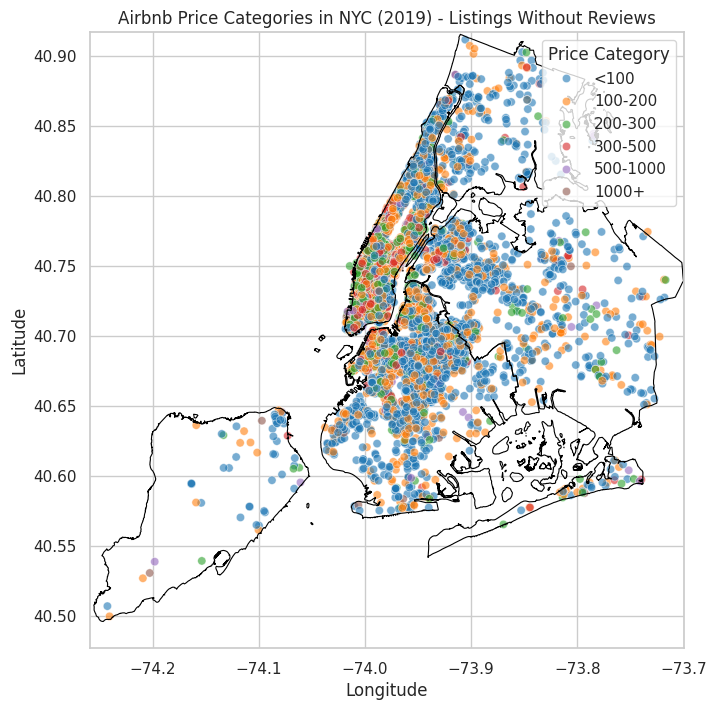

In [ ]:
# Use geopandas to fetch NYC boundaries
# Changed URL to download GeoJSON file directly
nyc_boundaries = gpd.read_file("https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=GeoJSON")

# Check the coordinate reference system (CRS) and reproject if needed
nyc_boundaries = nyc_boundaries.to_crs("EPSG:4326")  # Reproject to match GPS coordinates (latitude, longitude)

# Load Airbnb NYC 2019 data
airbnb_data = pd.read_csv("AB_NYC_2019.csv")

# Drop rows with missing or zero values in key columns
airbnb_data = airbnb_data.dropna(subset=['latitude', 'longitude', 'price', 'number_of_reviews'])
airbnb_data = airbnb_data[(airbnb_data['price'] > 0) & (airbnb_data['number_of_reviews'] == 0)]  # Include only listings with no reviews

# Create a binned price variable
bins = [0, 100, 200, 300, 500, 1000, float('inf')]  # Define bins
labels = ['<100', '100-200', '200-300', '300-500', '500-1000', '1000+']  # Define labels
airbnb_data['price_category'] = pd.cut(airbnb_data['price'], bins=bins, labels=labels, include_lowest=True)

# Define a custom color palette with distinct colors
custom_palette = {
    '<100': '#1f77b4',    # Blue
    '100-200': '#ff7f0e', # Orange
    '200-300': '#2ca02c', # Green
    '300-500': '#d62728', # Red
    '500-1000': '#9467bd', # Purple
    '1000+': '#8c564b'    # Brown
}

# Set the plot limits based on NYC bounds
nyc_bounds = {
    "longitude": (-74.259, -73.7),
    "latitude": (40.477, 40.917)
}

# Set up the scatter plot with NYC boundaries
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Create a scatter plot with latitude and longitude, color-coded by price category
scatter = sns.scatterplot(
    x=airbnb_data['longitude'],
    y=airbnb_data['latitude'],
    hue=airbnb_data['price_category'],
    palette=custom_palette,  # Use the custom color palette
    alpha=0.6,
    marker="o"
)

# Overlay NYC boundaries
nyc_boundaries.plot(ax=plt.gca(), edgecolor="black", facecolor="none", linewidth=0.8)

# Add titles and labels
plt.title("Airbnb Price Categories in NYC (2019) - Listings Without Reviews")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Add a legend for price categories
plt.legend(title="Price Category", loc='upper right')

plt.xlim(nyc_bounds["longitude"])
plt.ylim(nyc_bounds["latitude"])

plt.show()

**Numerical analysis of the influence longitude and latitude have on the price via a linear regression:**

First five rows of the dataset:
      id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
5  5099         Large Cozy 1 BR Apartment In Midtown East     7322   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   
5        Chris           Manhattan   Murray Hill  40.74767  -73.97500   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149      

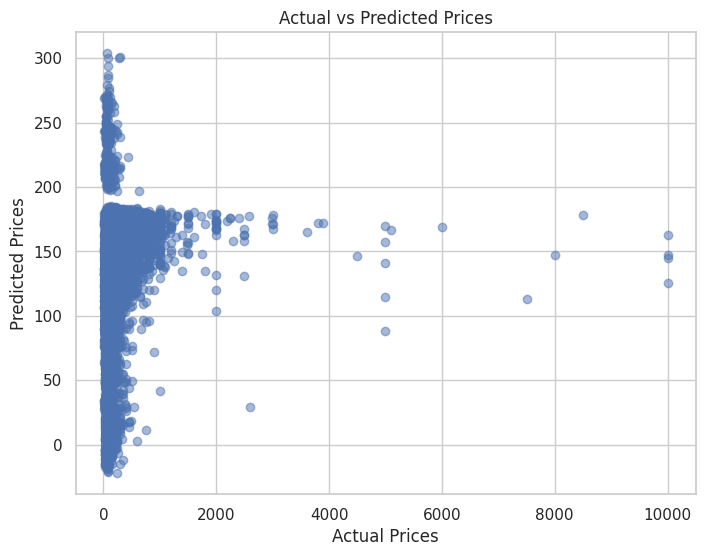

In [ ]:
# For both longitude and latitude, we have no missing values.
# Thus, no pre-processing in this regard is necessary.


# Load the dataset
try:
    # Replace 'AB_NYC_2019.csv' with the actual path to your dataset
    data = pd.read_csv('AB_NYC_2019.csv')
except FileNotFoundError:
    print("Error: Dataset not found. Ensure the file path is correct.")
    exit()

# Filter the dataset to include only listings with valid prices and reviews
airbnb_data = pd.read_csv('AB_NYC_2019.csv')
airbnb_data = airbnb_data[(airbnb_data['price'] > 0) & (airbnb_data['number_of_reviews'] > 0)]

# Inspect the first few rows to check column names
print("First five rows of the dataset:\n", airbnb_data.head())

# Select relevant columns and handle missing values
airbnb_data = airbnb_data[['price', 'longitude', 'latitude']].dropna()

# Convert the price column to numeric type if necessary
airbnb_data['price'] = pd.to_numeric(airbnb_data['price'], errors='coerce')

# Drop rows with non-numeric or missing price values
airbnb_data = airbnb_data.dropna()

# Prepare the independent (X) and dependent (y) variables
X = airbnb_data[['longitude', 'latitude']]  # Independent variables
y = airbnb_data['price']                    # Dependent variable (target)

# Add a constant to the model for the intercept
X = sm.add_constant(X)

# Fit the OLS model using statsmodels
model = sm.OLS(y, X).fit()

# Print the summary of the model, which includes coefficients, p-values, and more
print(model.summary())

# Predict prices using the fitted model
y_pred = model.predict(X)

# Plot predicted vs actual prices
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.show()

**Interpretation:**

We see that both longitude and latitude have an effect on the price which is for both highly statistically significant which can be seen at the very small p-values.

This means that being further North and further West both have a positive and statistically significant effect on the price.

**Next we calculate a regression to estimate the effect that the neighbourhood group has on the price. Since the neighborhood group is a categorical variable, some additional preparatory steps are now necessary.**



     id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
5  5099         Large Cozy 1 BR Apartment In Midtown East     7322   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   
5        Chris           Manhattan   Murray Hill  40.74767  -73.97500   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  20

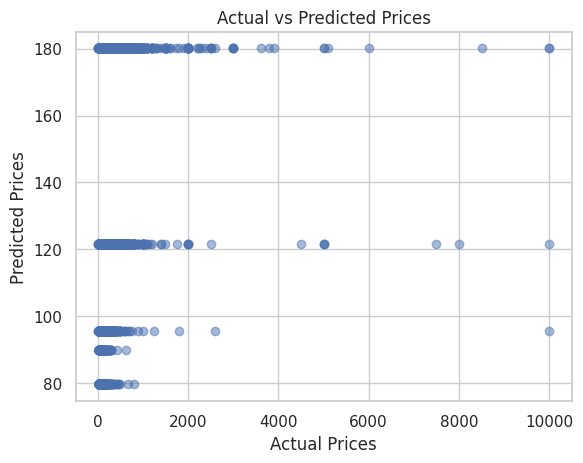

In [ ]:
# Load the dataset (ensure the correct path or method to read it)
airbnb_data = pd.read_csv('AB_NYC_2019.csv')
airbnb_data = airbnb_data[(airbnb_data['price'] > 0) & (airbnb_data['number_of_reviews'] > 0)]

# Inspect the first few rows to check column names
print(airbnb_data.head())

# Select relevant columns and handle missing values
# Adjust 'price' and 'neighbourhood' to match the exact column names in your dataset
airbnb_data = airbnb_data[['price', 'neighbourhood_group']].dropna()

# Convert the price column to a numeric type if it's not already
airbnb_data['price'] = pd.to_numeric(airbnb_data['price'], errors='coerce')

# Drop rows with non-numeric price values
airbnb_data = airbnb_data.dropna()

# Create dummy variables for the neighbourhood column
# Force the dtype to be numeric (e.g., int or float)
X = pd.get_dummies(airbnb_data['neighbourhood_group'], drop_first=True, dtype=float)

# Prepare the dependent variable
y = airbnb_data['price']

# Add a constant to the model for an intercept term
X = sm.add_constant(X)

# Fit the OLS model using statsmodels
model = sm.OLS(y, X).fit()

# Print the summary of the model, which includes coefficients, p-values, and more
print(model.summary())

# Optional: plot the predicted vs actual prices for visualization
plt.scatter(y, model.predict(X), alpha=0.5)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.show()

**Interpretation:**

We see that using an alpha-value of 5% only for Brooklyn and Manhattan the neighbourhood group has a statistically significant effect on the price.

As we can see, having an object listed in either Brooklyn or Manhattan has a positive effect on the price with the effect being even larger for Manhattan.

**Next we calculate a regression to estimate the effect that the neighbourhood has on the prive. Since the neighborhood is a categorical variable, some additional preparatory steps are now necessary.**

     id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  20

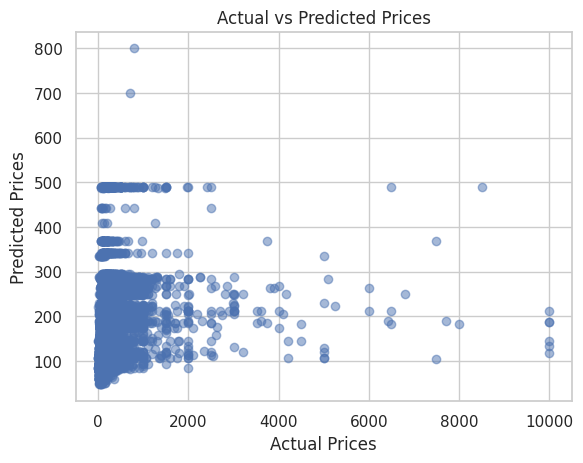

In [ ]:
# Load the dataset (ensure the correct path or method to read it)
# Replace 'path/to/airbnb.csv' with the actual path to your dataset
airbnb_data = pd.read_csv('AB_NYC_2019.csv')

# Inspect the first few rows to check column names
print(airbnb_data.head())

# Select relevant columns and handle missing values
# Adjust 'price' and 'neighbourhood' to match the exact column names in your dataset
airbnb_data = airbnb_data[['price', 'neighbourhood']].dropna()

# Convert the price column to a numeric type if it's not already
airbnb_data['price'] = pd.to_numeric(airbnb_data['price'], errors='coerce')

# Drop rows with non-numeric price values
airbnb_data = airbnb_data.dropna()

# Create dummy variables for the neighbourhood column
# Force the dtype to be numeric (e.g., int or float)
X = pd.get_dummies(airbnb_data['neighbourhood'], drop_first=True, dtype=float)

# Prepare the dependent variable
y = airbnb_data['price']

# Add a constant to the model for an intercept term
X = sm.add_constant(X)

# Fit the OLS model using statsmodels
model = sm.OLS(y, X).fit()

# Print the summary of the model, which includes coefficients, p-values, and more
print(model.summary())

# Optional: plot the predicted vs actual prices for visualization
plt.scatter(y, model.predict(X), alpha=0.5)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.show()

**Interpretation:**

After analysing the influence that the neighbourhood has on the price, we see no statistically significant effect for most of the neighbourhoods at an alpha level of 5%.

However, some neighbourhoods have a statistically significant effect on the price. Overall, 35 neighbourhoods have a positive influence on the price while for no neighbourhood a statistically negative influence on the price is found at an alpha level of 5%. This is probably due to the fact that most listings have a rather similar price with only some upwards deviations as we see in the visualisation of all listed objects and their prices on the Nes York City map.

**Summary of what the geographic analysis shows us:**

Neighbourhood group, longitude, and latitude have no missing values. Outliers are retained to capture high-priced special locations, and only listings with positive reviews are included to ensure bookings. Using a 5% significance level, we conduct two regressions. Results show that listings further north and west are associated with higher prices. Manhattan, Brooklyn, and Queens exhibit significantly higher prices, while Staten Island shows no significant effect. This is also shown by the visualisation that shows that Staten Island has less and cheaper listings than the other neighbourhood groups.

This suggests a potential low-price strategy for Staten Island to attract budget-conscious tourists unable to afford pricier areas.

# 7. Listing Name and Description

This notebook is for the UEO Machine Learning Group Project (Group 1).

[Reference CRISPDM]


## Name vs. Price Analysis

This notebook is part of an exploratory and analytical study examining the relationship between textual features (e.g., listing names) and pricing data in a dataset. It employs a combination of data cleaning, feature engineering, and machine learning techniques.

## Structure:

1. *Dataset Setup and Import*
2. *Preprocessing and Feature Engineering*
3. *Exploratory Data Analysis (EDA)*
4. *Correlation Analysis*
5. *Modeling and Prediction*
6. Model Diagnostic and Refinement


## 1.Project Overview
This project aims to analyse the New York City Airbnb Open Data (2019) to investigate the relationship between listing names and pricing. By leveraging textual features (e.g., word variety, common terms, and descriptive keywords), the analysis seeks to uncover insights that can help optimize listing titles for better visibility and pricing strategy.

The analysis addresses the following questions:

- How do textual features (e.g., word count, variety, and keywords) relate to pricing?

- Are there specific terms or patterns in listing names that correlate with higher prices?

- How can text processing and feature engineering enhance predictive models for pricing?

By answering these questions, this project aims to offer actionable insights into crafting effective listing descriptions to improve pricing and revenue.

##2. Notebook Setup
The first step is to verify that all necessary packages are installed and ready for use.

For this project, the following packages are required:

1. **Matplotlib**: Used for creating visualizations such as box plots, histograms, and scatter plots during exploratory data analysis and result presentation.

2. **Pandas**: Essential for data manipulation, cleaning, and feature engineering tasks.

3. **WordCloud**: Generates visual word clouds to explore patterns in the textual data.

4. **Scikit-learn**: Includes tools for feature extraction (e.g., TF-IDF) and modeling, such as regression and clustering algorithms.

5. **NLTK**: Provides tools for text processing, including cleaning and filtering stopwords.

6. **KaggleHub**: Facilitates downloading and managing datasets from Kaggle directly within the notebook.

7. **OS and Glob**: Enable file and directory management, and pattern-based file searching.

8. **Re and String**: Used for advanced text processing, such as cleaning and transforming textual data.

9. **Collections (Counter)**: Used to analyae the frequency of words or tokens in textual data.

The next step is to import the data.

In [ ]:
path = kagglehub.dataset_download("dgomonov/new-york-city-airbnb-open-data")

print("Path to dataset files:", path)
files = os.listdir(path)
print("Files in dataset:", files)

100%|██████████| 2.44M/2.44M [00:00<00:00, 87.9MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/dgomonov/new-york-city-airbnb-open-data/versions/3
Files in dataset: ['AB_NYC_2019.csv', 'New_York_City_.png']


The dataset file is then loaded into a Pandas DataFrame for further analysis:

In [ ]:
# Load the dataset into dataframe
df = pd.read_csv(os.path.join(path, 'AB_NYC_2019.csv'))
df.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

The following commands provide an overview of the dataset to help identify potential data preprocessing needs.

In [ ]:
# Display information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

**The data includes**:

- 16 columns (features)
- 48,895 rows (observations).
- various data types: float64 (3), int64 (7), and object (6).
- some columns contain null entries, which may require preprocessing.

This preliminary exploration helps identify potential issues like missing data, data types, or other inconsistencies that need to be addressed in the next steps.

**Data Inspection and Initial Analysis**

The first step in analyzing the dataset involves inspecting the data for potential issues and gaining an initial understanding of key features. The following checks and analyses were performed:

**1. Checking for Missing Values:**

- The name and price columns were inspected for missing values.
- This helps identify potential data cleaning steps, such as handling or imputing null entries in these critical features.

**2. Verifying Data Types:**

- The data types of the name and price columns were checked to ensure compatibility with further analysis.
- Correct data types (e.g., object for text and int or float for numerical data) are essential for accurate operations and visualizations.

In [ ]:
# check data types of 'name' and 'price'
print(df[['name', 'price']].dtypes)


name     object
price     int64
dtype: object


**3. Descriptive Statistics:**

Basic statistical measures for the price column, such as mean, median, standard deviation, and quantiles, were computed to understand its distribution and detect potential outliers.

In [ ]:
#display basic statistics for the 'price' column
print(df['price'].describe())

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64


**4. Exploring the *name* column:**

To better understand the *name* column and its variety, the following analyses were conducted:

- Unique Values: The column features a diverse range of descriptive listing titles, such as "Clean & quiet apt home by the park" and "Trendy duplex in the very heart of Hell's Kitchen."
- Random Samples: Examples of listing names include "Sun-filled loft," "Cozy And Stylish Modern Home," and "Central Park Brownstone Studio."

This exploration highlights the rich diversity in listing names, which can be a valuable resource for feature engineering. Identifying patterns, keywords, and other textual elements could provide insights into pricing and other trends within the dataset.



In [ ]:
#check unique values and sample of the 'name' column
print(df['name'].unique())
print(df['name'].sample(5))

['Clean & quiet apt home by the park' 'Skylit Midtown Castle'
 'THE VILLAGE OF HARLEM....NEW YORK !' ...
 'Sunny Studio at Historical Neighborhood'
 '43rd St. Time Square-cozy single bed'
 "Trendy duplex in the very heart of Hell's Kitchen"]
5209     Sunny Private Room Facing Beautiful Prospect Park
30534           Bright, spacious loft in the heart of Soho
16735              Art-filled Mid-Century Modern Apartment
34056    ☆Nice Private Room Near Park & Train in MANHAT...
14392                  Luxury 2200ft² 4Bed in East Village
Name: name, dtype: object


**Preprocessing and Feature Engineering**
To prepare the dataset for further analysis, the following preprocessing steps were carried out:

**1.Handling Missing Values:**

Rows with missing values in the name column were removed.
This ensures the data is consistent and ready for text-based feature engineering.

In [ ]:
# drop rows with missing values in 'name'
df.dropna(subset=['name'], inplace=True)

**Exploratory Data Analysis (EDA)**
To better understand the price column, a box plot was created to visualize its distribution:

**1. Box Plot for Price:**

The box plot highlights the spread of the price data, including the median and potential outliers.
Identifying outliers is an important step before applying transformations or capping extreme values.

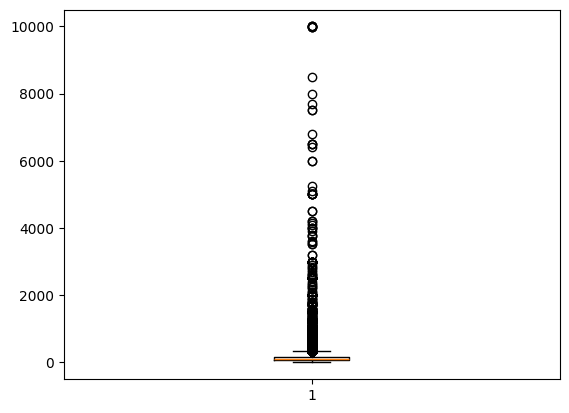

In [ ]:
# create a box plot for the 'price'
plt.boxplot(df['price'])
plt.show()

**Handling Outliers in Price Data**

During the exploratory data analysis, the initial box plot for the price column revealed the presence of numerous outliers. These extreme values significantly exceed the typical range of prices, as observed in the previous visualization. Outliers can distort the statistical analysis and may lead to misleading conclusions. To address this issue, the following steps were taken:

**1. Capping Outliers:**

- Prices were capped at the 95th percentile to limit the influence of extreme values.
- This ensures that the bulk of the data remains unaffected while removing the impact of a small number of unusually high prices.

In [ ]:
# cap prices at 95th percentile
cap_value = df['price'].quantile(0.95)
df['price_capped'] = df['price'].apply(lambda x: min(x, cap_value))

**2. Revised Box Plot:**

- A new box plot was generated using the capped *price_capped* column.
- This updated visualization provides a clearer and more representative view of the data, without being skewed by extreme outliers.

By capping the outliers, the data becomes more suitable for further analysis and modeling. This step helps focus on the majority of observations, ensuring that results and insights are not disproportionately influenced by rare, extreme values.

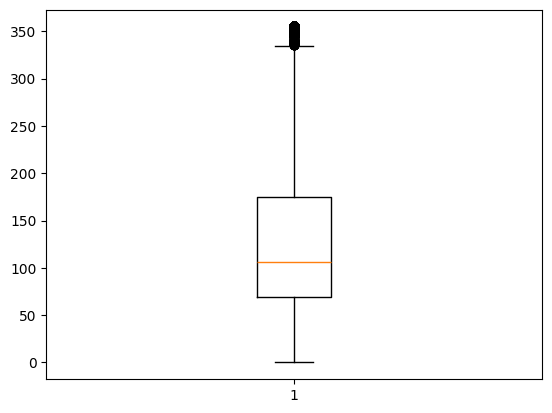

In [ ]:
# create a box plot for the 'price_capped'
plt.boxplot(df['price_capped'])
plt.show()

**Visualizing the Distribution of Prices**

To explore the raw price data, a histogram was created to display the distribution of prices across all listings. This visualization helps:

- Identify the overall spread and frequency of price values.
- Detect patterns such as clustering or gaps in certain price ranges.
- Observe potential skewness caused by extreme values (outliers) that could distort the analysis.

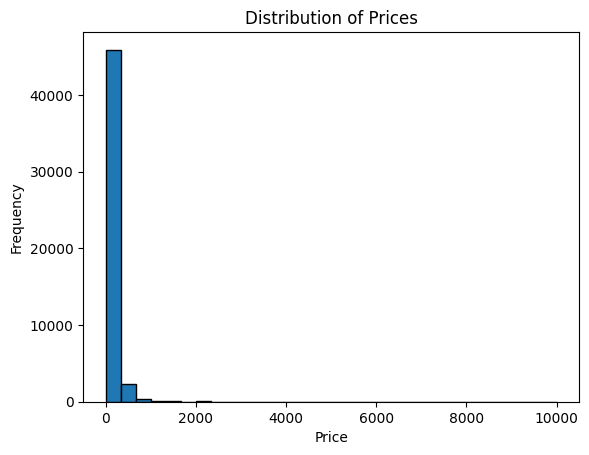

In [ ]:
# Plot a histogram of the 'price' column
plt.hist(df['price'], bins=30, edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Prices')
plt.show()

**Summary of the Price Distribution Histogram**

The histogram illustrates the distribution of prices in the dataset. Key observations include:

- Highly Skewed Distribution: The majority of listings fall within the lower price range, indicating a right-skewed distribution.
Most listings are concentrated below $500, with very few listings exceeding this value.

- Presence of Extreme Outliers: A small number of listings have prices exceeding 2,000 dollars, with some even reaching 10,000 dollars. These extreme values significantly extend the range of the data but represent a minimal portion of the total listings.

- Dominance of Low-Priced Listings: The frequency of listings sharply declines as prices increase, showing that low-priced properties dominate the dataset.

This distribution highlights the need for preprocessing steps, such as capping or transforming prices, to address the impact of extreme outliers and make the data more suitable for further analysis or modeling.

**Visualizing the Distribution of Capped Prices**
After addressing outliers in the price column by capping values at the 95th percentile, a histogram was created for the price_capped column. This step is crucial to:

- Understand how the capping process has affected the distribution of price data.
- Identify the most common price ranges where the majority of listings fall.
- Confirm that the extreme skewness caused by outliers has been mitigated.

The histogram provides a detailed visualization of the frequency of capped prices across different intervals, helping to ensure the dataset is now more representative and suitable for further analysis.

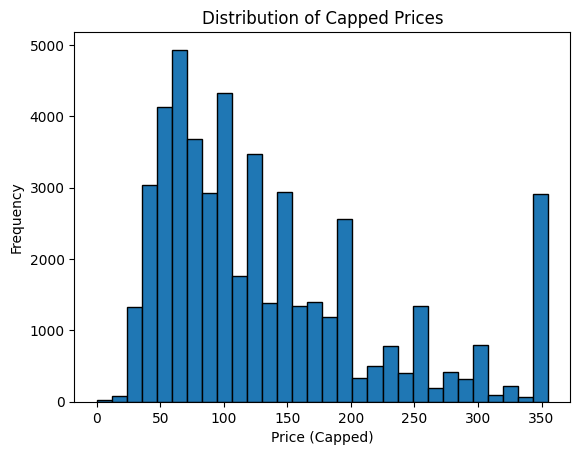

In [ ]:
# Plot a histogram of the 'price_capped' column
plt.hist(df['price_capped'], bins=30, edgecolor='black')
plt.xlabel('Price (Capped)')
plt.ylabel('Frequency')
plt.title('Distribution of Capped Prices')
plt.show()

**Summary of the Capped Price Distribution Histogram**

The histogram shows the distribution of prices after capping at the 95th percentile. Key observations include:

- **Reduced Impact of Outliers:** Compared to the uncapped price histogram, extreme values have been removed, resulting in a more compact and realistic distribution.
The data now focuses on prices up to $350, eliminating the influence of rare but extreme high-price listings.

- **Shift in Distribution:** The distribution is still slightly right-skewed but appears more balanced, with a clearer concentration of listings in specific price ranges.
Most listings fall between 50 and 150 dollars, indicating this is the typical price range in the dataset.

- **Clarity in Frequency Patterns:** Peaks in frequency are evident around 50, 100, and 150 dollars, providing insight into the most common price points for listings.

- **Improved Suitability for Analysis:** The capped prices provide a more meaningful representation of the data for further analysis, reducing the risk of skewed results due to extreme outliers.
This histogram confirms that capping prices effectively normalizes the data, making it ready for correlation analysis, feature engineering, or predictive modeling.

**Cleaning the Text in the name Column**

The name column contains text data that may include inconsistencies such as varying capitalization, punctuation, and unnecessary spaces. To ensure consistency and prepare the text for further analysis, the following cleaning steps were applied:

**1. Text Cleaning Function:**
A custom function, clean_text, was implemented to process each entry in the name column. The steps in the function include:

- **Converting to Lowercase:** Ensures all text is in the same case, which is essential for text-based feature extraction.
- **Removing Punctuation:** Replaces punctuation marks (e.g., commas, periods) with spaces to focus on the actual words.
- **Reducing Extra Spaces:** Replaces multiple spaces with a single space to standardize spacing.
- **Trimming Leading and Trailing Spaces:** Removes unnecessary spaces at the beginning or end of each entry.

In [ ]:
# clean the text in 'name' column
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Replace punctuation marks with a space
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Remove leading and trailing spaces
    text = text.strip()
    return text

**2. Applying the Cleaning Function:**
The cleaning function was applied to the *name* column, and the cleaned text was stored in a new column, *name_cleaned*.

In [ ]:
df['name_cleaned'] = df['name'].apply(clean_text)

**3. Inspecting Results:**

A preview of the cleaned text was displayed alongside the original text to ensure the cleaning process worked as intended.


In [ ]:
# display a few examples after cleaning
print(df[['name', 'name_cleaned']].head())

                                               name  \
0                Clean & quiet apt home by the park   
1                             Skylit Midtown Castle   
2               THE VILLAGE OF HARLEM....NEW YORK !   
3                   Cozy Entire Floor of Brownstone   
4  Entire Apt: Spacious Studio/Loft by central park   

                                      name_cleaned  
0                 clean quiet apt home by the park  
1                            skylit midtown castle  
2                   the village of harlem new york  
3                  cozy entire floor of brownstone  
4  entire apt spacious studio loft by central park  


Cleaning the text ensures consistency across the dataset, making it easier to analyze patterns, extract keywords, and create features from the text in the *name* column. This step is essential for preparing the data for further text analysis and modeling tasks.

**Analysing Word Frequencies in Listing Names**

To better understand the most common words in the *name_cleaned* column, the following steps were performed:

**1. Extracting Words and Counting Frequencies:**

- All the cleaned text from the *name_cleaned* column was combined into a single string and split into individual words.
- Using the Counter function, the frequency of each word was calculated, identifying the top 15 most frequently used words.

In [ ]:
# Split text into words and count frequencies
word_list = " ".join(df['name_cleaned']).split()
word_counts = Counter(word_list)
most_common_words = word_counts.most_common(15)  # Top 15 words

**2. Preparing Data for Visualization**

The top 15 most common words and their respective frequencies were extracted into separate lists, words and counts, to facilitate plotting.

In [ ]:
# Convert to separate lists for plotting
words, counts = zip(*most_common_words)

**3. Visualizing Word Frequencies:**

- A bar chart was created to display the most common words and their frequencies.
- The x-axis represents the words, and the y-axis shows how often each word appears in the dataset.
- Rotating the labels on the x-axis ensures better readability.

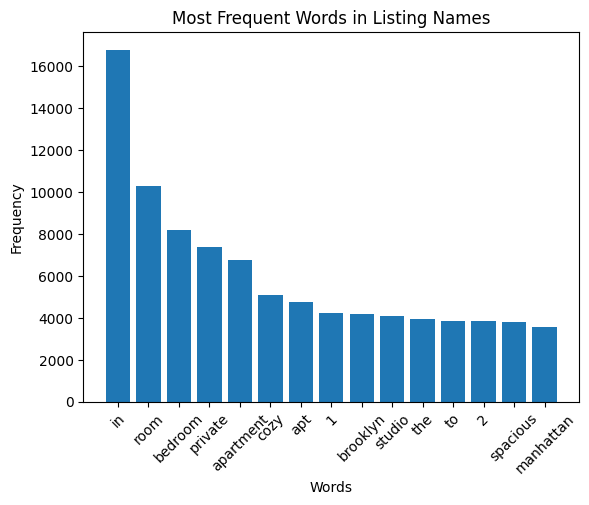

In [ ]:
# Plot
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most Frequent Words in Listing Names")
plt.show()

**Refining Word Frequency Analysis and Keyword Selection**

To ensure a cleaner and more meaningful analysis of the most frequent words in the *name_cleaned* column, certain adjustments were made to remove irrelevant or redundant terms:

**1. Stopwords Removal:** Common stopwords (e.g., "in", "the", "and") were removed using NLTK's predefined list, as these words do not contribute any analytical value.

In [ ]:
# download stopwords
stop_words = set(stopwords.words('english'))


1. Combining All Words:

- The text data in the *name_cleaned* column was combined into a single string. This step allows all words across all listings to be analysed collectively for their frequency.
- The combined string acts as the source for splitting into individual words for further processing.

In [ ]:
# combine all words into a single string
all_words = ' '.join(df['name_cleaned'])

**2. Custom Exclusion List:**

Additional words were excluded based on their lack of relevance or overlap with other analyses:
- **Geographical Terms:** Words such as "manhattan," "brooklyn," and "williamsburg" were excluded because the influence of location on price or listing trends is analysed separately in another part of the study.
- **Room/Listing Type Terms:** Words like "apartment," "studio," and "room" were excluded as these describe listing types, which are addressed in another section of the analysis.

The custom exclusion list ensures that the analysis focuses on descriptive and meaningful terms.

In [ ]:
# custom list of words to exclude. Excluded words include words indicating geographical location and room type, as those are analysed separately
custom_exclude = {'room', 'apt', 'bedroom', 'apartment', 'studio', 'brooklyn', 'manhattan', 'williamsburg', 'east', 'nyc', 'near', 'village', 'loft', 'home', 'bed', 'heart', 'central', 'private', 'location', 'west'}


**3. Filtered Word List:**

After combining all the text into a single string, the words were filtered to remove:
- Stopwords
- Words in the custom exclusion list
- Numbers and one-character words (e.g., "a").

The remaining words represent terms that provide more descriptive insights.


In [ ]:
# split the string into individual words and filter stop words and numbers
filtered_words = [
    word for word in all_words.split()
    if word not in stop_words and word not in custom_exclude and not word.isdigit() and len(word) > 1
]

**4. Top Words and Keyword Selection:**

After filtering the words from the *name_cleaned* column to remove stopwords, irrelevant terms, and numbers, the frequency of each remaining word was calculated using the Counter function from the collections module.

This step provides insight into the most commonly used descriptive terms in the listing names. These word frequencies are essential for identifying trends, patterns, or keywords that may play a role in influencing listing appeal, pricing, or other factors.

A predefined set of keywords (e.g., "cozy," "spacious," "beautiful") was selected for further analysis to focus on the descriptive aspects of listings.

In [ ]:
# count the frequency
word_counts = Counter(filtered_words)

# 10 most common words
top_10_words = [word for word, count in word_counts.most_common(10)]
print(top_10_words)

# list of key words to analyse

key_words = ['cozy', 'spacious', 'park', 'sunny', 'beautiful', 'large', 'modern', 'bright', 'luxury', 'new']

['cozy', 'spacious', 'park', 'sunny', 'beautiful', 'large', 'modern', 'bright', 'luxury', 'new']


**Keyword Presence in Listings**:

For each keyword, a new column was created in the DataFrame to indicate its presence (1 for presence, 0 for absence) in each listing name. This prepares the data for subsequent analysis of how descriptive terms correlate with price or popularity.

In [ ]:
# create columns indicating the presence of each keyword in the 'name' column
for word in key_words:
    df[word] = df['name_cleaned'].str.contains(word, case=False, na=False).astype(int)

# Combine 'name_cleaned' with the keyword columns
columns_to_display = ['name_cleaned'] + key_words  # Combining 'name_cleaned' with the keywords

# Display the selected columns
df[columns_to_display]

name_cleaned  cozy  spacious  \
0                       clean quiet apt home by the park     0         0   
1                                  skylit midtown castle     0         0   
2                         the village of harlem new york     0         0   
3                        cozy entire floor of brownstone     1         0   
4        entire apt spacious studio loft by central park     0         1   
...                                                  ...   ...       ...   
48890      charming one bedroom newly renovated rowhouse     0         0   
48891      affordable room in bushwick east williamsburg     0         0   
48892            sunny studio at historical neighborhood     0         0   
48893                43rd st time square cozy single bed     1         0   
48894  trendy duplex in the very heart of hell s kitchen     0         0   

       park  sunny  beautiful  large  modern  bright  luxury  new  
0         1      0          0      0       0       0       0    0  
1         0      0          0      0       0       0       0    0  
2         0      0          0      0       0       0       0    1  
3         0      0          0      0       0       0       0    0  
4         1      0          0      0       0       0       0    0  
...     ...    ...        ...    ...     ...     ...     ...  ...  
48890     0      0          0      0       0       0       0    1  
48891     0      0          0      0       0       0       0    0  
48892     0      1          0      0       0       0       0    0  
48893     0      0          0      0       0       0       0    0  
48894     0      0          0      0       0       0       0    0  

[48879 rows x 11 columns]

**Calculating the Correlation Between *price_capped* and Key Words**

To explore the relationship between listing prices and the presence of certain keywords, the correlation between the *price_capped* and the keyword columns was calculated using Pearson's correlation coefficient. This statistical measure shows the strength and direction of the linear relationship between two variables, where values closer to +1 or -1 indicate a stronger relationship, and values closer to 0 indicate a weaker relationship.

In [ ]:
# Calculate the correlation between 'price_capped' and 'key_words'
correlation_results = df[['price_capped'] + key_words].corr()['price_capped'].sort_values(ascending=False)

# Display the correlation results
print(correlation_results)


price_capped    1.000000
luxury          0.155622
modern          0.050464
park            0.038855
new             0.031883
beautiful       0.001166
bright         -0.005527
spacious       -0.009732
large          -0.011721
sunny          -0.063876
cozy           -0.127665
Name: price_capped, dtype: float64


**Plotting the Results**

In the previous analysis, the correlation between *price_capped* and the keywords was calculated, including the correlation of *price_capped* with itself, which is always 1.

To focus on the meaningful correlations between *price_capped* and the keywords, the correlation of *price_capped* with itself was excluded.



In [ ]:
# exclude the correlation of price with itself
correlation_results = correlation_results[correlation_results.index != 'price_capped']



The remaining correlations between price and the keywords were plotted in a bar chart. The x-axis represents the keywords, and the y-axis shows the strength of the correlation between each keyword and price. This visualization helps to identify which keywords have the strongest positive or negative relationships with *price*.

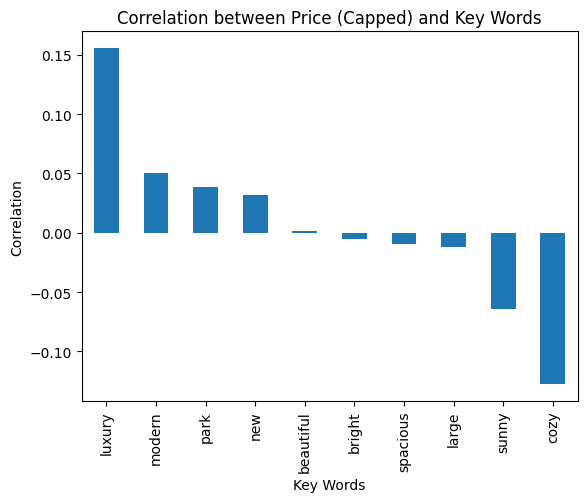

In [ ]:
# plot the correlation results
correlation_results.plot(kind='bar')
plt.xlabel('Key Words')
plt.ylabel('Correlation')
plt.title('Correlation between Price (Capped) and Key Words')
plt.show()

**Key Takeaways:**

The correlations observed between price_capped and the keywords are generally weak, and none of the correlations are statistically significant. In this context, a statistically significant correlation is typically considered to be above 0.5, indicating a strong relationship between the variables. Based on this threshold, the correlations in the chart do not reach this level of significance.

- Although "luxury" and "modern" show weak positive correlations, their impact on the price_capped is minimal and not statistically significant.
- Descriptive terms like "cozy," "beautiful," and "spacious" show little to no correlation with price_capped, suggesting that other factors (such as location, amenities, or room type) may have a more significant effect on price.

In conclusion, while these keywords may contribute to marketing the listings, they do not significantly influence the capped price of a listing. More substantial factors likely drive the pricing trends.

**Counting the Number of Words in Each Listing Name**

To analyse the length of the listing names, a new column was created in the DataFrame to store the number of words in each listing's *name_cleaned* column. This was achieved by applying a function to each entry in the *name_cleaned* column, which splits the text into words and counts the number of words.

In [ ]:
# Create a new column for the number of words in each 'cleaned_name'
df['word_count'] = df['name_cleaned'].apply(lambda x: len(x.split()))

# Display a few rows to verify
print(df[['name_cleaned', 'word_count']].head())

                                      name_cleaned  word_count
0                 clean quiet apt home by the park           7
1                            skylit midtown castle           3
2                   the village of harlem new york           6
3                  cozy entire floor of brownstone           5
4  entire apt spacious studio loft by central park           8


**Calculating the Correlation Between word_count and price_capped**

To explore the relationship between the length of the listing names (as represented by the *word_count* column) and the capped price (*price_capped*), the correlation between these two variables was calculated using Pearson's correlation coefficient. This measure helps to determine whether a longer listing name is associated with a higher or lower price.



In [ ]:
# calculate the correlation between 'word_count' and 'price_capped'
correlation_results = df[['word_count', 'price_capped']].corr()


To visualize the relationship between the number of words in the listing names (*word_count*) and the capped price (*price_capped*), a heatmap was created. This heatmap helps to clearly illustrate the strength and direction of the correlation between these two variables.

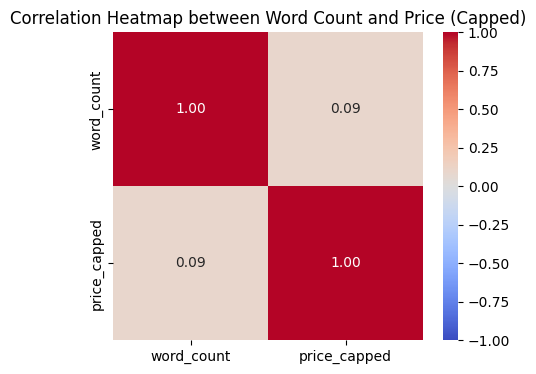

In [ ]:
# Plotting the heatmap
plt.figure(figsize=(5, 4))  # Adjust the figure size if needed
sns.heatmap(correlation_results, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, center=0, cbar=True)

# Add title and labels
plt.title('Correlation Heatmap between Word Count and Price (Capped)')
plt.show()


The weak positive correlation between the number of words in a listing's name and its price suggests that there is no strong or meaningful relationship between the length of the listing name and the price, even after capping.
Listings with more words in their titles tend to have slightly higher prices, but this effect is minimal and likely not a reliable factor for pricing.


To further explore the relationship between the number of words in listing names (*word_count*) and the capped price (*price_capped*), a scatter plot was created. This visualization allows us to observe how the two variables are related and identify any patterns or trends.

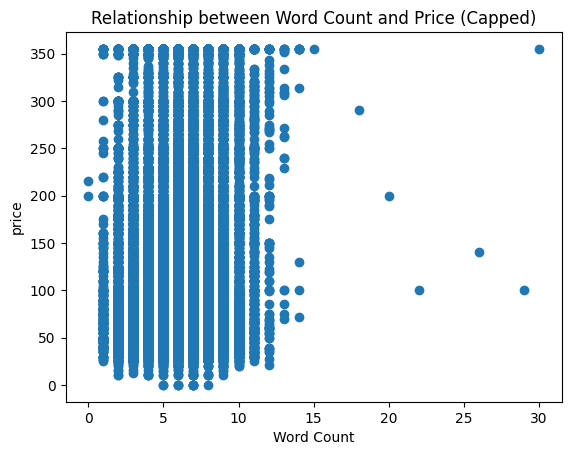

In [ ]:
# scatter plot to visualise that relationship
plt.scatter(df['word_count'], df['price_capped'])
plt.xlabel('Word Count')
plt.ylabel('price')
plt.title('Relationship between Word Count and Price (Capped)')
plt.show()

Overall, the scatter plot shows that there is no clear pattern or strong relationship between the number of words in the listing name and the capped price. The majority of the listings, especially those with fewer words, exhibit a wide range of prices, and the outliers do not form any clear trend.



**Filtering the Data for Manhattan and Entire Home/Apt Listings**

To focus the analysis on a specific subset of the data, I chose to filter the dataset for listings located in Manhattan and those categorized as Entire home/apt. This selection was made for the following reasons:

- **Manhattan:** Manhattan is one of the most popular and highly priced neighborhoods in New York City. By focusing on Manhattan, we can analyse how listings in this area behave relative to other neighborhoods. This allows us to isolate potential pricing trends and patterns specific to Manhattan, which might differ from other areas of the city.

- **Entire Home/Apt:** For a more standardized analysis, I selected Entire home/apt listings, as they typically offer more privacy and amenities compared to shared or private rooms, making them more comparable for pricing analysis.
Additionally, entire homes or apartments are often priced higher than shared spaces or private rooms, which makes them a valuable category for analysing the impact of features or location on pricing.

By narrowing the dataset to Manhattan and Entire home/apt listings, we can focus on a subset of high-end properties that are more likely to follow certain pricing trends, enabling us to make more targeted insights.

In [ ]:
# Create a regular expression pattern that matches any of the keywords
pattern = '|'.join(key_words)  # This joins the keywords with a '|' (OR) to create a regex pattern

# Filter the data for Manhattan, Entire home/apt, and listings containing any of the keywords in 'name_cleaned'
filtered_df = df[(df['neighbourhood_group'] == 'Manhattan') &
                 (df['room_type'] == 'Entire home/apt') &
                 (df['name_cleaned'].str.contains(pattern, case=False, na=False))]

# Ensure filtering is done correctly
print(filtered_df.head())

      id                                              name  host_id host_name  \
4   5022  Entire Apt: Spacious Studio/Loft by central park     7192     Laura   
5   5099         Large Cozy 1 BR Apartment In Midtown East     7322     Chris   
9   5238                Cute & Cozy Lower East Side 1 bdrm     7549       Ben   
10  5295                  Beautiful 1br on Upper West Side     7702      Lena   
19  7750                 Huge 2 BR Upper East  Cental Park    17985      Sing   

   neighbourhood_group    neighbourhood  latitude  longitude        room_type  \
4            Manhattan      East Harlem  40.79851  -73.94399  Entire home/apt   
5            Manhattan      Murray Hill  40.74767  -73.97500  Entire home/apt   
9            Manhattan        Chinatown  40.71344  -73.99037  Entire home/apt   
10           Manhattan  Upper West Side  40.80316  -73.96545  Entire home/apt   
19           Manhattan      East Harlem  40.79685  -73.94872  Entire home/apt   

    price  ...  spacious  

**Correlation Heatmap between Capped Price and Keywords for Entire Homes/Apartments in Manhattan**

In this analysis, a correlation heatmap was created to explore the relationship between the *price_capped* and the presence of certain keywords in the listing names for **Manhattan Entire home/apt listings**.

**1. Creating Keyword Presence Columns:**

A new column was created for each keyword to indicate its presence in the name_cleaned column. These columns are binary (0 or 1), where 1 means the keyword is present in the listing name and 0 means it is absent.

In [ ]:
# Create columns indicating the presence of each keyword in 'name_cleaned' for the filtered DataFrame
for word in key_words:
    filtered_df.loc[:, word] = filtered_df['name_cleaned'].str.contains(word, case=False, na=False).astype(int)

**2. Correlation Calculation**

The correlation matrix was computed for the *price_capped* and the keyword presence columns. This matrix provides insights into how strongly each keyword correlates with the capped price.

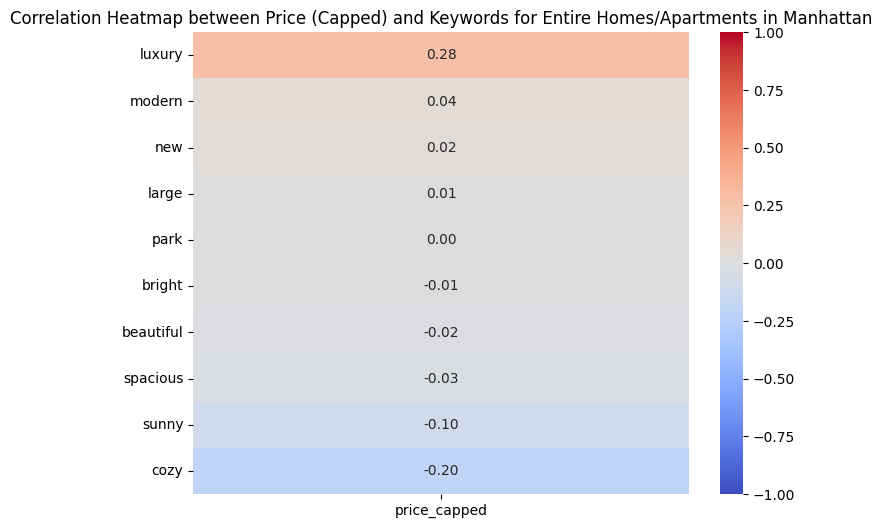

In [ ]:
# Calculate the correlation matrix between 'price_capped' and the keyword columns
correlation_matrix = filtered_df[['price_capped'] + key_words].corr()

# Select only the correlation of 'price_capped' with the keywords (exclude keyword-to-keyword correlations)
correlation_price_keywords = correlation_matrix[['price_capped']].drop('price_capped', axis=0)

# Plot the heatmap for the correlation between 'price_capped' and keywords
plt.figure(figsize=(8, 6))  # Adjust the figure size if necessary
sns.heatmap(correlation_price_keywords.sort_values(by='price_capped', ascending=False),
            annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, center=0)

# Add title and labels
plt.title('Correlation Heatmap between Price (Capped) and Keywords for Entire Homes/Apartments in Manhattan')
plt.show()

**Interpretation of the Correlation Heatmap between *price_capped* and keywords for Entire Homes/Apartments in Manhattan**

**Key Takeaways**

While "luxury" shows the strongest positive correlation, it is still below 0.5, indicating a weak relationship with the capped price. The rest of the keywords, including "cozy" and "sunny", have weak or negative correlations, meaning they do not significantly influence pricing.

It's important to note that choosing only Manhattan or Entire home/apt listings did not significantly change the correlation results compared to the analysis of the whole dataset. The relationships observed for the keywords in Manhattan listings are similar to those seen across the broader dataset, indicating that the observed trends in keyword correlations are consistent regardless of the filter applied.

**Text-Based Features for Listing Name Analysis**

This section calculates several text-based features to analyze the content and uniqueness of the listing names in the dataset. The features include TF-IDF scores, word variety, and the presence of rare words. These features provide insights into the characteristics of listing names and their potential relationship with pricing or other dataset attributes.

**1. Calculating TF-IDF Scores:**

The TF-IDF (Term Frequency-Inverse Document Frequency) scores are calculated for each listing name in the name_cleaned column. The TfidfVectorizer from scikit-learn is used to transform the cleaned listing names into a matrix of TF-IDF scores. The tfidf_score is the sum of the TF-IDF scores across all words in the listing name. A higher TF-IDF score indicates that a listing name contains more distinctive words, which may help in identifying listings with more unique or specialized descriptions.

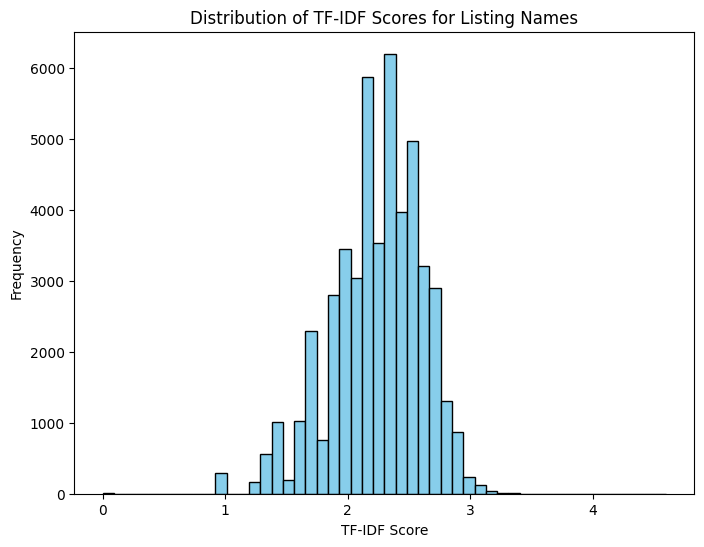

In [ ]:
# calculate TF-IDF scores
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['name_cleaned'])
df['tfidf_score'] = tfidf_matrix.sum(axis=1).A1

# Plot the distribution of TF-IDF scores
plt.figure(figsize=(8, 6))
plt.hist(df['tfidf_score'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of TF-IDF Scores for Listing Names')
plt.xlabel('TF-IDF Score')
plt.ylabel('Frequency')
plt.show()

**Key Insights:**

- The majority of listings have moderate TF-IDF scores (around 2), indicating that most listings contain a mix of unique and common terms in their names.

- A small percentage of listings have high TF-IDF scores, suggesting that they contain highly distinctive or specialized words.

- Listings with very low TF-IDF scores tend to use common, frequently appearing words that do not contribute much to distinguishing the listing.

**2. Calculating Word Variety:**

The *word_variety* feature measures the diversity of unique words in each listing name. It is computed by using the *set(x.split())* method to determine the number of distinct words in the name. A higher *word_variety* score reflects a greater variety of words, which may indicate that the listing name is more detailed or descriptive.

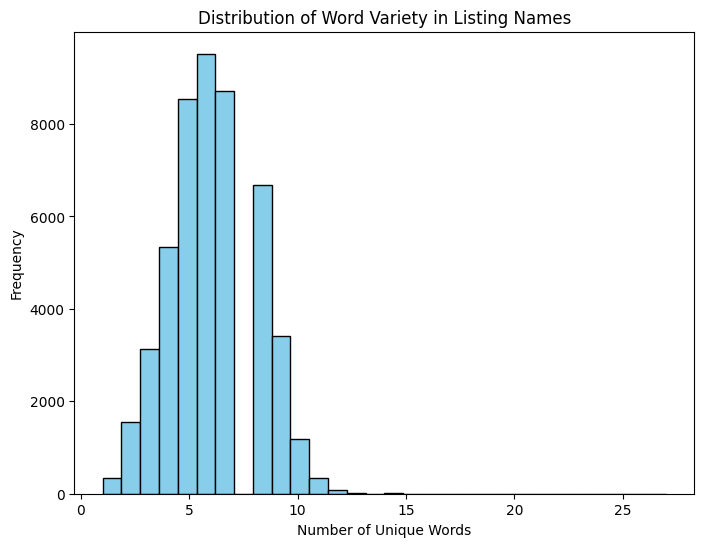

In [ ]:
# calculate number of unique words
df['word_variety'] = df['name'].apply(lambda x: len(set(x.split())))

# Plot the distribution of word variety (number of unique words in each listing name)
plt.figure(figsize=(8, 6))
plt.hist(df['word_variety'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Word Variety in Listing Names')
plt.xlabel('Number of Unique Words')
plt.ylabel('Frequency')
plt.show()

*Key Insights:*

- Most listings have moderate word variety, with names containing around 4 to 6 unique words.
- Listings with more than 10 unique words are relatively rare, suggesting that shorter, more concise names are more common.
- The low number of listings with very few unique words indicates that repetitive or overly simple names are not prevalent.

**3. Word Frequency Analysis:**

A *word_counts* series is generated to determine the frequency of each word appearing across all listing names. The *value_counts()* method is used to count the occurrences of each word within the dataset. This process highlights both the most commonly used words and the least frequent ones in the listing names.

In [ ]:
# find word frequencies
word_counts = pd.Series(" ".join(df['name']).split()).value_counts()

**4. Identifying Rare Words:**

Rare words are defined as those that appear only once in the entire dataset. These words are considered less common and could potentially carry unique meaning for individual listings. These rare words are identified by filtering the *word_counts* for words that appear only once in the dataset.

In [ ]:
# words appearing once in the dataset
rare_words = word_counts[word_counts == 1].index

**5. Checking for the Presence of Rare Words:**

A new column, *contains_rare_word*, is created to identify whether a listing name contains any of the rare words. This is done by checking if any word in the *name_cleaned column* appears in the list of rare words. This feature helps us track listings that contain unique or uncommon words.

In [ ]:
# names containing rare words
df['contains_rare_word'] = df['name_cleaned'].apply(lambda x: any(word in rare_words for word in x.split()))

**6. Displaying Preview**

To verify the newly created features, we display a preview of the DataFrame. This includes the name_cleaned, tfidf_score, word_variety, and contains_rare_word columns for a few rows. This preview helps to ensure that the features are calculated and added correctly.

In [ ]:
# display preview
print(df[['name_cleaned', 'tfidf_score', 'word_variety', 'contains_rare_word']].head())

                                      name_cleaned  tfidf_score  word_variety  \
0                 clean quiet apt home by the park     2.619510             8   
1                            skylit midtown castle     1.664184             3   
2                   the village of harlem new york     2.425640             6   
3                  cozy entire floor of brownstone     2.196681             5   
4  entire apt spacious studio loft by central park     2.788817             7   

   contains_rare_word  
0               False  
1                True  
2               False  
3               False  
4               False  


**Correlation Analysis of Listing Name Features with Price**

In this section, the correlation between the listing price and the text-based features, TF-IDF scores and word variety, is analyzed. These features provide insights into the distinctiveness and diversity of listing names and their potential relationship with the price of the listing.

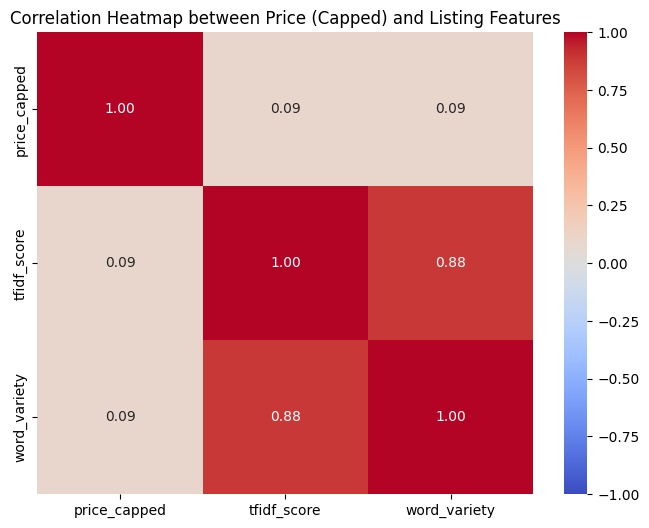

In [ ]:
# check correlation with price
correlation_results = df[['price_capped', 'tfidf_score', 'word_variety']].corr()['price_capped'].sort_values(ascending=False)

# Calculate the correlation matrix
correlation_matrix = df[['price_capped', 'tfidf_score', 'word_variety']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap between Price (Capped) and Listing Features')
plt.show()

**Key Insights:**

- The correlation between *price_capped* and both *tfidf_score* and *word_variety* is very weak, suggesting that the uniqueness or variety of words in the listing names has a minimal impact on the capped price.
- Word variety and TF-IDF score are strongly correlated with each other, meaning listings with a higher variety of words tend to have more distinctive word choices as measured by TF-IDF.

**Scatter Plots for Price vs. Listing Name Features**

In this section, scatter plots are used to visually explore the relationship between listing price and two key text-based features: TF-IDF score and word variety.

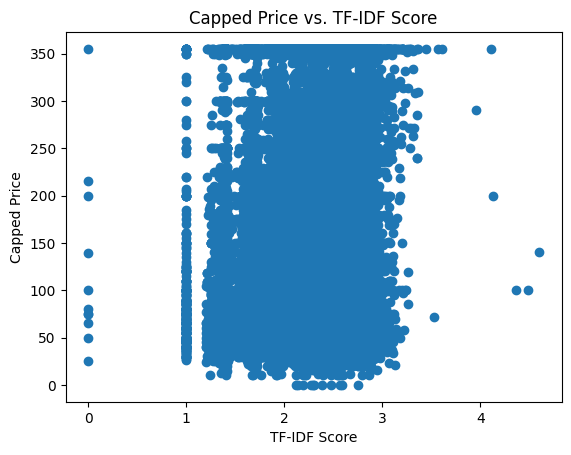

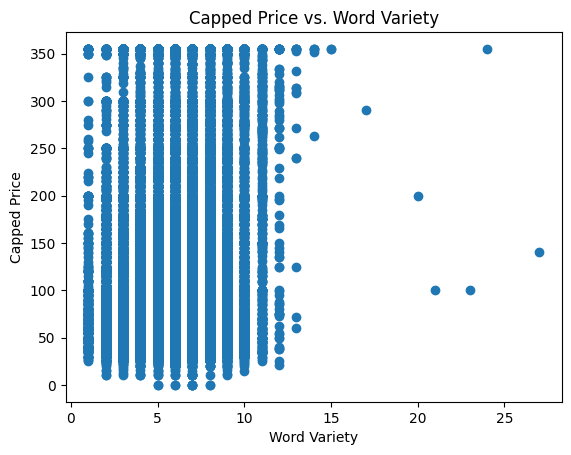

In [ ]:
# Scatter plot for capped price vs. tfidf_score
plt.scatter(df['tfidf_score'], df['price_capped'])
plt.xlabel('TF-IDF Score')
plt.ylabel('Capped Price')
plt.title('Capped Price vs. TF-IDF Score')
plt.show()

# Scatter plot for capped price vs. word_variety
plt.scatter(df['word_variety'], df['price_capped'])
plt.xlabel('Word Variety')
plt.ylabel('Capped Price')
plt.title('Capped Price vs. Word Variety')
plt.show()

**Interpretation**

**1. Price vs. TF-IDF Score Scatter Plot**

**Key Insights:**

- Capped price is not strongly correlated with the TF-IDF score of the listing names. The data shows that even listings with highly distinctive names (higher TF-IDF scores) tend to be priced at lower levels.

- The outliers with higher prices do not form a consistent pattern with TF-IDF scores, suggesting that factors other than the uniqueness of the listing name likely play a more significant role in determining the price.

- The majority of listings are priced low, regardless of their name distinctiveness.

**2. Capped Price vs. Word Variety Scatter Plot**

**Key Insights:**

- Word variety does not appear to have a significant impact on the capped price.
- Most listings, regardless of the word variety in their names, are priced at the lower end of the market.
- A few outliers with higher prices do not form a consistent pattern with word variety, suggesting that other factors are more likely driving the price

**Linear Regression Analysis of Price with Listing Name Features**

In this section, a linear regression model is used to examine the relationship between price (dependent variable) and two text-based features—TF-IDF score and word variety (independent variables). The purpose of this regression analysis is to assess whether the distinctiveness of the listing name (as measured by TF-IDF) and the diversity of words (as measured by word variety) can help explain variations in listing prices.

**1. Adding a Constant:**
To perform the linear regression, a constant (intercept) is added to the independent variables using the *sm.add_constant* function. This ensures that the model includes an intercept term.

**2. Fitting the Regression Model:**
The Ordinary Least Squares (OLS) method is used to fit the regression model, where price is the dependent variable, and TF-IDF score and word variety are the independent variables.
The model is fit using the *sm.OLS()* function from the Statsmodels library.

In [ ]:
# Define independent variables
independent_vars = df[['tfidf_score', 'word_variety']]

# Add constant for regression intercept
independent_vars = sm.add_constant(independent_vars)

# Fit the regression model
model = sm.OLS(df['price_capped'], independent_vars).fit()

# Print the summary of the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           price_capped   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     217.6
Date:                Tue, 26 Nov 2024   Prob (F-statistic):           8.01e-95
Time:                        23:29:17   Log-Likelihood:            -2.8716e+05
No. Observations:               48879   AIC:                         5.743e+05
Df Residuals:                   48876   BIC:                         5.743e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           94.3196      3.064     30.784   

**Interpretation**

- **R-squared: 0.009**
This is the proportion of variance in price explained by the model. A value of 0.009 is very low, suggesting that the TF-IDF score and word variety explain very little of the variation in price. Essentially, this indicates that these features are not strong predictors of price.

- **P-value: 8.01e-95**
This is the p-value associated with the F-statistic. A very small value means the model is statistically significant, but the weak R-squared indicates the model's explanatory power is weak.

- **TF-IDF Score Coefficient: 12.83** — Each 1 unit increase in TF-IDF score is associated with a 12.83 unit increase in price, but the relationship is weak.

- **Word Variety Coefficient: 1.83** — The number of unique words in the listing name has a very small effect on the price, with each additional unique word contributing just 1.83 units to the price.

**Q-Q plot**

The Q-Q plot is used to assess the normality of the model's residuals. If the residuals are normally distributed, the points should align with the reference 45-degree line. Significant deviations suggest that the residuals may not follow a normal distribution, indicating potential issues with the model.

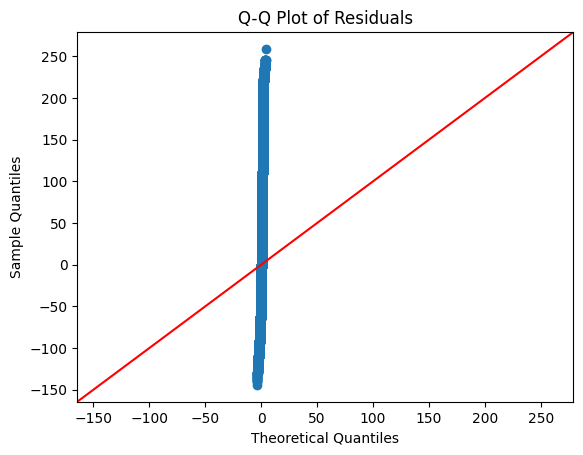

In [ ]:
# Extract residuals
residuals = model.resid

# Q-Q plot
sm.qqplot(residuals, line='45')  # line='45' adds a line for perfect normality
plt.title('Q-Q Plot of Residuals')
plt.show()

**Log Transformation of Price and Regression Model**

To address the non-normality of the residuals and stabilize the variance, the log transformation is applied to the price variable. Specifically, *log_price_capped* is calculated as the natural logarithm of *price_capped*, with an addition of 1 to avoid taking the logarithm of zero.

This transformation helps reduce skewness and improve the model’s fit. After the transformation, an OLS regression model is fitted using the log-transformed price as the dependent variable and the same independent variables as before.

In [ ]:
df['log_price_capped'] = np.log(df['price_capped'] + 1)  # Add 1 to avoid log(0)
model_log = sm.OLS(df['log_price_capped'], independent_vars).fit()
print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:       log_price_capped   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     181.3
Date:                Tue, 26 Nov 2024   Prob (F-statistic):           3.72e-79
Time:                        23:50:18   Log-Likelihood:                -46745.
No. Observations:               48879   AIC:                         9.350e+04
Df Residuals:                   48876   BIC:                         9.352e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.3921      0.022    196.098   

**This model has improved compared to the previous one:**

- **Feature Significance:** The TF-IDF score now shows a significant positive relationship with price, which was not the case in the earlier model. However, word variety remains insignificant.

- **Residuals:** The log transformation improved the normality of residuals slightly, but they are still not perfectly normal.

- **R-squared:** The R-squared remains low (0.007), indicating the model still does not explain much of the price variation.

This model can be improved by adding more variables like room type or number of reviews

**Summary**

According to this analysis, there is minimal correlation between the features of listing names and their respective prices. The findings suggest that while names may provide some contextual information, they do not significantly influence or predict pricing trends.

Visualizations and statistical measures included in the notebook reinforce this conclusion, showing weak or negligible relationships between name-related attributes and price variability. Other factors likely play a more substantial role in determining prices.

This analysis underscores the importance of focusing on more relevant features when evaluating pricing strategies.